In [4]:
# math tools
import numpy as np
import math

# file handling tools 
import os
import uproot
import pickle
import pickletools

# data handling tools
import copy
from   functools import partial

# time handling 
import datetime 
import time
import pytz
# establish eastern time for timer later
est = pytz.timezone('America/New_York')

# plotting tools
import matplotlib
import matplotlib.pyplot as     plt
from   matplotlib        import colors
import matplotlib.colors as     mcolors

# data math tools
import scipy.optimize    as     scipy
from   scipy.interpolate import interp1d
from   scipy.ndimage     import gaussian_filter1d
from   scipy.signal      import find_peaks
from   scipy.optimize    import curve_fit
from   scipy.optimize    import least_squares


# LZStyle file:
if None != os.getenv('NERSC_HOST'):
    import matplotlib.font_manager as font_manager
    font_manager.fontManager.addfont('/global/cfs/cdirs/lz/physics/WS/SR1/msttcorefonts/Times_New_Roman.ttf')
plt.style.use('/global/cfs/cdirs/lz/users/dkodroff/LZStyle/SetLZStyle.mplstyle')
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'

import sys
print(sys.version)
import scipy
print(scipy.__version__)


3.8.9 (default, May 21 2021, 08:55:19) 
[GCC 8.2.0]
1.4.1


# Data Type and Plot Settings

In [5]:
"""
Data and plot naming settings for:

   * SR3LENR Final Version data set 
                  &
   * 2024 April 1 - 2024 Septempber 18: run over https://gitlab.com/katievictoriaw/SR3RunsAnalysis
"""

# declare labels for plots
data_str        = "WS_2023Mar_2024Sept"
data_plot_str   = "WS 2023 Mar. 27 - 2024 Sept. 18"
source_str      = "Xe131m"
source_plot_str = "Xe 131m"

# use data set with vetoes?
vetoes_available = True

# apply the vetoes?
use_vetoes       = False

# which vetoes?
use_hotspot_veto = False
use_etrain_veto  = False
use_muon_veto    = False

# create veto strings for file and plot naming
if use_hotspot_veto or use_etrain_veto or use_muon_veto:
    veto_str      = "_vetoes"
    veto_plot_str = " (Selected DQ Cuts Applied)"
else:
    veto_str      = ""
    veto_plot_str = "No DQ Cuts"

# Global Functions

## General

In [6]:
def function_timer(func):
    """
    Methods to call:
    _____________________________________________________
    1. Define functions that always use timer as
    
             @function_timer
             def some_function(a, b):
    _____________________________________________________   
    2. Define functions not to always use timer normally 
       and call the timer when wanted by doing
             
             function_timer(some_function)(a, b)
    _____________________________________________________
    """
    def wrapper(*args, **kwargs):
        
        # declare and print starting time 
        start_time     = time.time()
        start_time_utc = datetime.datetime.fromtimestamp(start_time, pytz.utc)
        start_time_est = start_time_utc.astimezone(est)
        print(f"START: {start_time_est.strftime('%Y-%m-%d %H:%M:%S %Z%z')}")
    
        try:
            # run the function
            result = func(*args, **kwargs)
        except Exception as e:
            end_time = time.time()
            end_time_utc = datetime.datetime.fromtimestamp(end_time, pytz.utc)
            end_time_est = end_time_utc.astimezone(pytz.timezone('America/New_York'))
            print(f"END:   {end_time_est.strftime('%Y-%m-%d %H:%M:%S %Z%z')}")
            raise e
        else:
            # declare and print end time
            end_time       = time.time()
            end_time_utc   = datetime.datetime.fromtimestamp(end_time, pytz.utc)
            end_time_est   = end_time_utc.astimezone(pytz.timezone('America/New_York'))
            print(f"END:   {end_time_est.strftime('%Y-%m-%d %H:%M:%S %Z%z')}")

        # find and print elapsed time
        elapsed_time     = end_time - start_time
        hours, remainder = divmod(elapsed_time, 3600)
        minutes, seconds = divmod(remainder, 60)
        print()
        print(f"RUNTIME: {int(hours):02} hrs, {int(minutes):02} mins, {seconds:05.2f} secs")
        print()
        return result if result is not None else None

    
    return wrapper


In [7]:
# Function to load data from a pickle file and display it

def load_and_display_data(file_name, flag=False):
    """
    ____________________________________________________________________________________________
    FUNC INFO:
    (string) file_name: the path of the file from the location where this function is called 
                        e.g. 'file_name.pickle' OR 'subfolder/file_name.pickle'
                        
    (bool)   flag:      DEFAULT False, set True to view the objects stored in the files
    ____________________________________________________________________________________________
    USAGE:
    * To use for one file:
        loaded_data      = load_and_display_data('file_name_path')
        
    * To use for list of files: 
        file_names       = ['file_name1_path', 'file_name2_path', 'file_name3_path', ...]
        loaded_data_list = [load_and_display_data(file_name) for file_name in file_names] 
    ____________________________________________________________________________________________
    """
    
    with open(file_name, 'rb') as file:
        
        # load the data 
        loaded_data = pickle.load(file)
        
        if flag == True:

            print(f"_____________________________________________________________________________________________")
            print()
            print(f"Loaded Data from '{file_name}':")
            
            # only print keys for dictionaries
            if isinstance(loaded_data, dict):
                var_names = list(loaded_data.keys())
                for var_name in var_names:
                    print(f"  {var_name}")
            
    return loaded_data

In [8]:
# Sum of the min & max of (a, b, c)
def hilo(a, b, c):
    if c < b: b, c = c, b
    if b < a: a, b = b, a
    if c < b: b, c = c, b
    return a + c

def get_complementary_color(color, alpha=0.2):
    rgba          = mcolors.to_rgba(color, alpha=alpha)
    r, g, b, _    = rgba
    k             = hilo(r, g, b)
    complementary = (k - r, k - g, k - b)
    
    # Lighten the complementary color by blending it with white
    lightened_complementary = tuple((1 - alpha) + alpha * c for c in complementary)
    
    return lightened_complementary

def darken_color(color, alpha=0.2):

    rgba = mcolors.to_rgba(color, alpha=alpha)
    r, g, b, _ = rgba
    
    # Blend the color with black
    blended = (r * (1 - alpha), g * (1 - alpha), b * (1 - alpha))
    
    return blended

def darken_color_list(color_list, alpha):
    """
    Lighten each color in the color list.
    
    Parameters:
    - color_list: List of colors (each can be a named color or an RGBA tuple).
    - alpha: Amount of blending with white.
    
    Returns:
    - List of lightened colors.
    """
    return [darken_color(color, alpha) for color in color_list]

def lighten_color(color, alpha):
    """
    Lighten the color by blending with white.
    
    Parameters:
    - color: Input color (can be a named color or an RGBA tuple).
    - alpha: Amount of blending with white (0 is no blending, 1 is full white).
    
    Returns:
    - Blended color as an RGB tuple.
    """
    rgba = mcolors.to_rgba(color)  # Convert color to RGBA format
    r, g, b, _ = rgba  # Extract color channels and alpha
    
    # Blend the color with white
    factor = 1 - alpha
    lightened = (r + (1 - r) * factor, 
                 g + (1 - g) * factor, 
                 b + (1 - b) * factor)
    
    return lightened

def lighten_color_list(color_list, alpha):
    """
    Lighten each color in the color list.
    
    Parameters:
    - color_list: List of colors (each can be a named color or an RGBA tuple).
    - alpha: Amount of blending with white.
    
    Returns:
    - List of lightened colors.
    """
    return [lighten_color(color, alpha) for color in color_list]


## List & Array Handling

In [9]:
def get_list_shape(lst):
    """
    Function to print the shape of a list
    """
    
    list_shape = []
    
    for x in range(len(lst)):
        y = len(lst[x])
        
        list_shape.append(y)
        
    return list_shape

In [10]:
def remove_index(data, index):
    """
    Function to remove selected index from an array or list
    """
    
    mask        = np.ones(data.shape, dtype=bool)
    mask[index] = False
    masked_data = data[mask]
    
    return masked_data

In [11]:
def get_var_name(var):
    """
    Function that returns the name of a variable as a str 
    """
    
    for name, value in globals().items():
        if value is var:
            return name 

In [12]:
def remove_all_but_one_trailing_zero(arr, flag=False):
    """
    Function that removes all but one trailing zero from an array 
    """
    
    # Find the indices of zeros
    zero_indices = np.where(arr == 0)[0]
    
    if flag:
        print(f"zero_indices = {zero_indices}")

    if len(zero_indices) > 0:
        # Create a mask initialized to False
        mask = np.ones_like(arr, dtype=bool)

        # Keep the first zero after a sequence of non-zeros
        for i in range(len(arr)):
            if arr[i] == 0 and arr[i - 1] == 0:
                mask[i] = False

    return mask 

## Dictionary Handling

In [13]:
def create_var_dict(var_list):
    """
    Function that creates a dictionary from a list of variables
    """
    
    # get variable names
    var_names = [get_var_name(var) for var in var_list]
    
    # combine variable_list and variable_name
    var_dict = dict(zip(var_names, var_list))
    
    return var_dict

In [14]:
def print_keys(var_dict):
    """
    Function that prints the keys of a dictionary 
    """
    
    # get name of var_dict
    var_dict_name = get_var_name(var_dict)
    print(f"variables in dictionary: {var_dict_name}")
    print()
    for key in var_dict.keys():
        print(key)

In [15]:
def remove_key(dictionary, key_index):
    """
    Function that removes a key-value pair from a dictionary.
    """
    
    removed_key = list(dictionary.keys())[key_index]
    value = dictionary.pop(removed_key)
    new_dict = dictionary.copy()  # Create a copy of the original dictionary
    dictionary[removed_key] = value  # Restore the original dictionary
    
    return new_dict

In [16]:
def add_key(dictionary, new_var, new_var_name_str):
    """
    Function that adds a key-value pair to a dictionary.
    """
    
    # declare new variable to add to the dictionary 
    new_key   = new_var_name_str
    new_value = new_var
    
    # Add a new variable to the dictionary
    dictionary[new_key] = new_value
    
    return dictionary

In [17]:
def apply_mask_to_dict(input_dict, mask, remove_suffix=None, add_suffix=None, flag=False):
    """
    Function that applies a mask to an entire dictionary at once
    """
    
    # create blank dictionary
    new_dict = {}
    
    for name, value in input_dict.items():
        
        if flag == True:
            print(f"{name} = {value}")
            
        # apply mask to each variable in input_dict
        new_value = value[mask]
        
        # remove suffix if remove_suffix is specified 
        if remove_suffix:
            name = name.replace(remove_suffix, "")
        
        # add suffix if add_suffix is specified
        if add_suffix:
            new_name = name + add_suffix
        
        else:
            new_name = name 
            
        # fill new_dict with new names and their corresponding new values
        new_dict[new_name] = new_value 
        
    return new_dict

## 

# Import Formatted Data Pickles

In [18]:
# list files

file_prefix      =  "/global/cfs/cdirs/lz/users/wild/ALPACA/modules/SR3RunsAnalysis/" \
                    "analysis/pickles-data_setup/"

file_suffix_list = ["calT_int_dict", "dT_slice_dict", "rqs_dict_allcalTdT", \
                    "dT_slice_dict_6dT", "rqs_dict_allcalTdT_6dT", \
                    "rqs_dict_allcalTdT_6dT_w_pie_masks"]

file_list = []
for i in range(len(file_suffix_list)):
    file_suffix = file_suffix_list[i]
    file_list_i = f"{file_prefix}{data_str}{veto_str}-{file_suffix}.pickle"
    file_list.append(file_list_i)

In [19]:
# load files

loaded_data_list = [load_and_display_data(file_name, flag=False) for file_name in file_list]

In [20]:
calT_int_dict                      = loaded_data_list[0]
dT_slice_dict                      = loaded_data_list[1]
rqs_dict_allcalTdT                 = loaded_data_list[2]
dT_slice_dict_6dT                  = loaded_data_list[3]
rqs_dict_allcalTdT_6dT             = loaded_data_list[4]
rqs_dict_allcalTdT_6dT_w_pie_masks = loaded_data_list[5]


## view dict info, if desired

In [21]:
print_keys(rqs_dict_allcalTdT[0][0])

variables in dictionary: None

dT_us
x_cm
y_cm
r2_cm2
ell_mask
num_events_tot
num_events_sel


# Find Wall Position of a Single ($t_{cal}$, $t_{drift}$) Slice

## functions

### function pieces

#### math functions

In [22]:
def f_linear(x, m, b):
    y = m * x + b
    return y

In [23]:
# Define the residuals function (difference between observed and model data)
def residuals(params, r2, data, sigma):
    return (f_linear_gaussian_wrapper(r2, *params) - data) / sigma

In [24]:
def order_of_magnitude(x):
   
    x_scale = 10**np.floor(np.log10(abs(x)))
    
    return x_scale

In [25]:
def regularize_covariance(pcov, epsilon=1e-6):
    """
    Regularizes a covariance matrix by adding epsilon to the diagonal.
    
    Parameters:
        pcov (ndarray): Covariance matrix to regularize.
        epsilon (float): Small value to add to diagonal.
    
    Returns:
        ndarray: Regularized covariance matrix.
    """
    regularized_pcov = pcov + epsilon * np.eye(len(pcov))
    return regularized_pcov

In [26]:
def simplify_covariance_matrix(pcov, threshold=1e-12):
    """
    Simplifies a covariance matrix by zeroing out small covariances.

    Parameters:
        pcov (ndarray): Input covariance matrix.
        threshold (float): Minimum value for covariances to retain.

    Returns:
        ndarray: Simplified covariance matrix.
    """
    pcov_simplified = np.copy(pcov)
    small_elements = np.abs(pcov_simplified) < threshold
    pcov_simplified[small_elements] = 0  # Zero out small elements
    return pcov_simplified


#### histogram helper functions

In [27]:
# get lists of numbers of events 

def get_num_events_arr(rqs_dict, rqs_dict_has_pie_slices=False):
    
    # get number of slices
    num_calT_ints = len(rqs_dict)
    num_dT_ints   = len(rqs_dict[0])
    if rqs_dict_has_pie_slices:
        num_pie_slices = len(rqs_dict[0][0]['num_events_tot_pie'])

    # declare empty arrays to hold the number of events
    if rqs_dict_has_pie_slices:
        num_events_tot_arr = np.zeros((num_calT_ints, num_dT_ints, num_pie_slices))
        num_events_sel_arr = np.zeros((num_calT_ints, num_dT_ints, num_pie_slices))
        
    else:
        num_events_tot_arr = np.zeros((num_calT_ints, num_dT_ints))
        num_events_sel_arr = np.zeros((num_calT_ints, num_dT_ints))

    # loop through the dictionaries
    for calT, dT_dict in rqs_dict.items():
        for dT, data in dT_dict.items():
            
            if rqs_dict_has_pie_slices:
                for pie in range(num_pie_slices): 
                    
                    num_events_tot_arr[calT][dT][pie] = data['num_events_tot_pie'][pie]
                    num_events_sel_arr[calT][dT][pie] = data['num_events_sel_pie'][pie]
                
            else:
                num_events_tot_arr[calT][dT] = data['num_events_tot']
                num_events_sel_arr[calT][dT] = data['num_events_sel']
    
    return num_events_tot_arr, num_events_sel_arr


In [28]:
# calculate multiplier for the number of histogram bins

def calculate_bins_multiplier_1calTdT(num_events, min_events, max_events, 
                                      min_multiplier=1.6, max_multiplier=0.6):
    """
    Calculates the bins multiplier based on the number of events using linear interpolation.
    
    Parameters:
    - num_events (float or array-like): Number of events for which to calculate the multiplier.
    - min_events (float): Minimum number of events in the dataset.
    - max_events (float): Maximum number of events in the dataset.
    - min_multiplier (float): Multiplier value corresponding to min_events (default: 1.6).
    - max_multiplier (float): Multiplier value corresponding to max_events (default: 0.6).
    
    Returns:
    - bins_multiplier (float or array-like): Interpolated multiplier(s).
    """
    # # Linear interpolation formula
    # slope = (max_multiplier - min_multiplier) / (max_events - min_events)
    # bins_multiplier = min_multiplier + slope * (num_events - min_events)
    
#     # Normalize num_events to a range [0, 1]
#     norm_events = (num_events - min_events) / (max_events - min_events)
    
#     # Exponential decay from min_multiplier to max_multiplier
#     bins_multiplier = max_multiplier + (min_multiplier - max_multiplier) * np.exp(-norm_events)
    
    # Normalize num_events to a range [0, 1]
    norm_events = (num_events - min_events) / (max_events - min_events)
    
    # Exponential increase from max_multiplier to min_multiplier 
    bins_multiplier = max_multiplier + (min_multiplier - max_multiplier) * (np.exp(-norm_events))
    
#     # Normalize num_events to a [0, 1] range
#     normalized = (num_events - min_events) / (max_events - min_events)
    
#     # Apply quadratic transformation (e.g., y = ax^2 + bx + c)
#     # We can use a simple quadratic like y = a*x^2 + b*x + c to fit the range
#     bins_multiplier = min_multiplier + (max_multiplier - min_multiplier) * (normalized ** 2)
    
    return bins_multiplier


In [29]:
def calculate_bins_multiplier_allcalTdT(num_events_arr, 
                                        min_multiplier=1.6, max_multiplier=0.6, 
                                        counter_calT=False):
    
    # get numbers of calT, dT slices
    num_calT_ints = len(num_events_arr)
    num_dT_ints   = len(num_events_arr[0])
    
    # get max and nonzero min numbers of events
    min_events = min(num_events_arr[num_events_arr > 0])
    max_events = max(num_events_arr[num_events_arr > 0])
    
    # set up empty array to hold multipliers
    bins_multiplier_arr = np.zeros((num_calT_ints, num_dT_ints))
    
    for calT in range(num_calT_ints):
        
        if counter_calT:
            print(f"calT[{calT}]")
            
        for dT in range(num_dT_ints):
            
            # get num_events for current calT, dT slice
            num_events = num_events_arr[calT][dT]
            
            if num_events == 0:
                
                # set bins multiplier for empty single calT, dT to be zero
                bins_multiplier = 0
                
            else:
                
                # get bins multiplier for one calT, dT
                bins_multiplier = \
                    calculate_bins_multiplier_1calTdT(num_events, min_events, max_events, 
                                                      min_multiplier=min_multiplier, 
                                                      max_multiplier=max_multiplier)

                # store bins multiplier in bins_multiplier_arr
                bins_multiplier_arr[calT][dT] = bins_multiplier
            
    return bins_multiplier_arr
    

### linear/gaussian

In [30]:
def f_linear_gaussian(x, mu, sig, split, m, b, 
                      force_split_gte_mu, 
                      fixed_m=None, fixed_b=None):
    
    # Ensure split is always greater than or equal to mu if the flag is set
    if force_split_gte_mu:
        split = max(split, mu)
    
    # define mask to split the fit into linear and gaussian parts
    mask = x < split
    
    # fixed m option
    if fixed_m is not None:
        m=fixed_m
        
    # fixed b option
    if fixed_b is not None:
        b=fixed_b
    
    # left side - linear fit 
    linear        = m * x[mask] + b
    y_split       = linear[-1]
    
    # right side - gaussian
    exp_val_split = - (   split - mu)**2 / (2 * sig**2)
    amp           = y_split / np.exp(exp_val_split)
    exp           = - (x[~mask] - mu)**2 / (2 * sig**2)
    gaussian      = amp * np.exp(exp)
    
    # combine functions
    fit         = np.zeros_like(x)
    fit[ mask]  = linear
    fit[~mask]  = gaussian
    
    return fit
    

In [31]:
# def f_linear_gaussian(x, mu, sig, split, m, b, 
#                       force_split_gte_mu):
    
#     # Ensure split is always greater than or equal to mu if the flag is set
#     if force_split_gte_mu:
#         split = max(split, mu)
    
#     # define mask to split the fit into linear and gaussian parts
#     mask = x < split
    
#     # left side - linear fit 
#     linear        = m * x[mask] + b
#     y_split       = linear[-1]
    
#     # right side - gaussian
#     exp_val_split = - (   split - mu)**2 / (2 * sig**2)
#     amp           = y_split / np.exp(exp_val_split)
#     exp           = - (x[~mask] - mu)**2 / (2 * sig**2)
#     gaussian      = amp * np.exp(exp)
    
#     # combine functions
#     fit         = np.zeros_like(x)
#     fit[ mask]  = linear
#     fit[~mask]  = gaussian
    
#     return fit
    

In [32]:
# def f_linear_gaussian_fixed_params(x, mu, sig, split, m, b, 
#                                    force_split_gte_mu,
#                                    fixed_m=None, fixed_b=None):
#     """
#     Wrapper function to allow fixing m and b in f_linear_gaussian.
#     If fixed_m or fixed_b is not None, those values will be used instead of the input parameters.
#     """
#     # Override with fixed values if specified
#     if fixed_m is not None:
#         m = fixed_m
#     if fixed_b is not None:
#         b = fixed_b
        
#     # Call the full function with fixed parameters
#     return f_linear_gaussian(x, mu, sig, split, m, b, force_split_gte_mu=force_split_gte_mu)

# Define the wrapper that fixes b
def f_linear_gaussian_fixed_b(x, mu, sig, split, m, force_split_gte_mu, fixed_b):
    """
    Wrapper to fix 'b' while optimizing the other parameters.
    """
    # Call the main function with 'b' fixed
    return f_linear_gaussian(x, mu, sig, split, m, fixed_b, force_split_gte_mu)

In [33]:
def f_linear_gaussian_partial_derivs_at_max(x_sel, mu, sig, xSplit, m, b):
    
    """
    gaussian part will always contain the height point
    the derivatives of tarot at max height are done with gaussian part 
    
    Gauss = A e^(-(x - mu)^2 / (2 sig**2))
    __________________________________________________________________
    for variable x_sel (x-value of the selected maximum count, i.e. the height r2 bin value):

        m      - slope
        b      - intercept
        xSplit - x-value at split between linear and guassian
        mu     - gaussian mean
        sig    - gaussian standard deviation
    
    fit = ( (m * xSplit + b) / e^(-(xSplit - mu)**2 / (2 sig**2)) ) * e^(-(x_sel - mu)**2 / (2 sig**2))
    
    fit =   (m * xSplit + b) * e^((xSplit - mu)**2 / (2 sig**2)) * e^(-(x_sel - mu)**2 / (2 sig**2))
    
        y_split   (m, b, xSplit)    =  (m * xSplit + b)
        split_exp (xSplit, mu, sig) =  (xSplit - mu)**2 / (2 * sig**2)
        gauss_exp (mu, sig)         = -(x_sel  - mu)**2 / (2 * sig**2)
        
    fit = y_split * e^split_exp * e^gauss_exp
    """

    # get tarot pieces
    ySplit    =  (m * xSplit + b)
    split_exp =  (xSplit - mu)**2 / (2 * sig**2)
    gauss_exp = -(x_sel  - mu)**2 / (2 * sig**2)
    
    # partials of y_split
    dYSplit_dMu      = 0
    dYSplit_dSig     = 0
    dYSplit_dXSplit  = m
    dYSplit_dM       = xSplit
    dYSplit_dB       = 1.
    
    # partials of split_exp
    dSplitExp_dMu     = -(xSplit - mu)    / sig**2
    dSplitExp_dSig    = -(xSplit - mu)**2 / sig**3
    dSplitExp_dXSplit =  (xSplit - mu)    / sig**2
    dSplitExp_dM      = 0
    dSplitExp_dB      = 0
    
    # partials of gauss_exp
    dGaussExp_dMu     =  (x_sel - mu)    / sig**2
    dGaussExp_dSig    =  (x_sel - mu)**2 / sig**3
    dGaussExp_dXSplit = 0
    dGaussExp_dM      = 0
    dGaussExp_dB      = 0
    
    # tarot function at max value gaussian 
    tarot = ySplit * np.exp(split_exp) * np.exp(gauss_exp)
    
    # partials of tarot wrt tarot pieces
    dFit_dYSplit   = np.exp(split_exp) * np.exp(gauss_exp)
    dFit_dSplitExp = ySplit * split_exp * np.exp(split_exp) * np.exp(gauss_exp)
    dFit_dGaussExp = ySplit * np.exp(split_exp) * gauss_exp * np.exp(gauss_exp)
    
    # partials wrt parameters [mu, sig, split, m, b]
    dFit_dMu     = dFit_dYSplit * dYSplit_dMu     + dFit_dSplitExp * dSplitExp_dMu     + dFit_dGaussExp * dGaussExp_dMu
    dFit_dSig    = dFit_dYSplit * dYSplit_dSig    + dFit_dSplitExp * dSplitExp_dSig    + dFit_dGaussExp * dGaussExp_dSig
    dFit_dXSplit = dFit_dYSplit * dYSplit_dXSplit + dFit_dSplitExp * dSplitExp_dXSplit + dFit_dGaussExp * dGaussExp_dXSplit
    dFit_dM      = dFit_dYSplit * dYSplit_dM      + dFit_dSplitExp * dSplitExp_dM      + dFit_dGaussExp * dGaussExp_dM
    dFit_dB      = dFit_dYSplit * dYSplit_dB      + dFit_dSplitExp * dSplitExp_dB      + dFit_dGaussExp * dGaussExp_dB
    
    return dFit_dMu, dFit_dSig, dFit_dXSplit, dFit_dM, dFit_dB

In [34]:
def f_linear_gaussian_uncertainty(popt, pcov, x_sel):
    
    # get the values of the params
    mu, sig, split, m, b = popt
    
    # get the partial derivs
    df_dmu, df_dsig, df_dsplit, df_dm, df_db = \
        f_linear_gaussian_partial_derivs_at_max(x_sel, mu, sig, split, m, b)
    
    # get the sig2 vals of the params
    d2_mu    = pcov[0,0]
    d2_sig   = pcov[1,1]
    d2_split = pcov[2,2]
    d2_m     = pcov[3,3]
    d2_b     = pcov[4,4]
    
    # get the covariances
    cov_mu_sig    = pcov[0,1]
    cov_mu_split  = pcov[0,2]
    cov_mu_m      = pcov[0,3]
    cov_mu_b      = pcov[0,4]
    cov_sig_split = pcov[1,2]
    cov_sig_m     = pcov[1,3]
    cov_sig_b     = pcov[1,4]
    cov_split_m   = pcov[2,3]
    cov_split_b   = pcov[2,4]
    cov_m_b       = pcov[3,4]
    
    # get the uncertainty 
    d2f =  df_dmu**2    * d2_mu    + df_dsig**2 * d2_sig \
         + df_dsplit**2 * d2_split + df_dm**2   * d2_m   \
         + df_db**2     * d2_b                          \
         + 2 * cov_mu_sig    * df_dmu    * df_dsig   \
         + 2 * cov_mu_split  * df_dmu    * df_dsplit \
         + 2 * cov_mu_m      * df_dmu    * df_dm     \
         + 2 * cov_mu_b      * df_dmu    * df_db     \
         + 2 * cov_sig_split * df_dsig   * df_dsplit \
         + 2 * cov_sig_m     * df_dsig   * df_dm     \
         + 2 * cov_sig_b     * df_dsig   * df_db     \
         + 2 * cov_split_m   * df_dsplit * df_dm     \
         + 2 * cov_split_b   * df_dsplit * df_db     \
         + 2 * cov_m_b       * df_dm     * df_db 
    
    df = np.sqrt(d2f)
    
    return df

In [35]:
def f_linear_gaussian_uncertainty_postmax(popt, pcov, N, sig_N):
    
    """
    N and sig_N can be single values or arrays
    """
    
    # get the values of the params
    mu, sig, s, m, b = popt
    
    # get the sig2 vals of the params
    d2_mu  = pcov[0,0]
    d2_sig = pcov[1,1]
    d2_s   = pcov[2,2]
    d2_m   = pcov[3,3]
    d2_b   = pcov[4,4]
    d2_N   = sig_N**2
    
    # get the partial derivs
    ln_term   = N / (m * s + b)
    in_sqrt   = (s - mu)**2 - 2 * sig**2 * np.log(ln_term)
    if in_sqrt < 0:
        print(f"Warning: negative term inside sqrt: {in_sqrt}")
    sqrt_term = (in_sqrt)**(-1/2)
    dr2_dmu   = 1 - (s - mu) * sqrt_term
    dr2_dsig  = - 2 * sig * np.log(ln_term) * sqrt_term
    dr2_ds    = ((1/2) * (s - mu) + sig**2 * m / (m * s + b)) * sqrt_term
    dr2_dm    = (sig**2 * s / (m * s + b)) * sqrt_term
    dr2_db    = (sig**2 / (m * s + b)) * sqrt_term
    dr2_dN    = (- sig**2 / N) * sqrt_term
    
    # # Calculate magnitudes
    # jacobian_magnitudes = {
    #     'dr2_dmu':  np.abs(dr2_dmu),
    #     'dr2_dsig': np.abs(dr2_dsig),
    #     'dr2_ds':   np.abs(dr2_ds),
    #     'dr2_dm':   np.abs(dr2_dm),
    #     'dr2_db':   np.abs(dr2_db),
    #     'dr2_dN':   np.abs(dr2_dN)
    # }

    
    # get the covariances
    cov_mu_sig = pcov[0,1]
    cov_mu_s   = pcov[0,2]
    cov_mu_m   = pcov[0,3]
    cov_mu_b   = pcov[0,4]
    cov_sig_s  = pcov[1,2]
    cov_sig_m  = pcov[1,3]
    cov_sig_b  = pcov[1,4]
    cov_s_m    = pcov[2,3]
    cov_s_b    = pcov[2,4]
    cov_m_b    = pcov[3,4]
    
    # get the uncertainty 
    d2r2 =  dr2_dN**2   * d2_N   + dr2_dmu**2 * d2_mu    \
          + dr2_dsig**2 * d2_sig + dr2_ds**2  * d2_s \
          + dr2_dm**2   * d2_m   + dr2_db**2  * d2_b     \
          + 2 * cov_mu_sig * dr2_dmu  * dr2_dsig   \
          + 2 * cov_mu_s   * dr2_dmu  * dr2_ds \
          + 2 * cov_mu_m   * dr2_dmu  * dr2_dm     \
          + 2 * cov_mu_b   * dr2_dmu  * dr2_db     \
          + 2 * cov_sig_s  * dr2_dsig * dr2_ds \
          + 2 * cov_sig_m  * dr2_dsig * dr2_dm     \
          + 2 * cov_sig_b  * dr2_dsig * dr2_db     \
          + 2 * cov_s_m    * dr2_ds   * dr2_dm     \
          + 2 * cov_s_b    * dr2_ds   * dr2_db     \
          + 2 * cov_m_b    * dr2_dm   * dr2_db
    
    dr2 = np.sqrt(d2r2)
    
    return dr2
    

#### not in use 

In [36]:
# # create function settings
#         if extremely_peaked_cond:
            
#             # define value for whether to force the split parameter to be greater than the mu parameter
#             force_split_gte_mu = False
            
#             # define paramter bounds
#             lb_lin_gauss = np.array([mu0 - 5.0 * sig0, 0.5 * sig0, split0 - 0.5 * sig0,    0.00010, b0 - 2])
#             ub_lin_gauss = np.array([mu0 + 2.0 * sig0, 1.5 * sig0, split0 + 3.0 * sig0, m0 + 0.002, b0 + 2])
        
#         elif at_least_rather_peaked_cond and not extremely_peaked_cond:
            
#             # define value for whether to force the split parameter to be greater than the mu parameter
#             force_split_gte_mu = False
            
#             # define paramter bounds
#             lb_lin_gauss = np.array([mu0 - 5.0 * sig0, 0.5 * sig0, split0 - 0.5 * sig0,    0.00010, b0 - 20])
#             ub_lin_gauss = np.array([mu0 + 0.5 * sig0, 1.2 * sig0, split0 + 0.5 * sig0, m0 + 0.005, b0 + 20])
            
#         else: 
            
#             # define value for whether to force the split parameter to be greater than the mu parameter
#             force_split_gte_mu = True
            
#             lb_lin_gauss = np.array([mu0 - 0.5 * sig0, 0.5 * sig0, split0             ,    0.00010, b0 - 20])
#             ub_lin_gauss = np.array([mu0 + 0.2 * sig0, 1.2 * sig0, split0 + 0.5 * sig0, m0 + 0.005, b0 + 20])

In [37]:
# # function piece that would use a linear fit to find the wall position

#     # get points for linear fit to find wall position
#         if flag: 
#             print()
#             print(f"number of points after height point: {len(smooth_r2[smooth_r2 >= r2_height])}")
#             print(f"last r2 value: {smooth_r2[-1]}")
#             print(f"last nonzero n r2 value: {smooth_r2[smooth_n>0][-1]}")
#             print(f"number of points after height point and before last nonzero n: {len(smooth_r2[(smooth_r2 >= r2_height) & (smooth_n>0)])}")
#             print()
            
#         # select desired data for fitting a line to the data to find the r2 value 
#         # use single smoothed: smooth_r2 and smooth_n
#         # in this case, we want the r2 values starting at the height point, 
#         # and ending at the last nonzero count value bin
#         sel_bins_mask         = (smooth_r2 >= r2_height) & (smooth_n > 0)
#         smooth_r2_postmax     = smooth_r2[sel_bins_mask]
#         smooth_n_postmax      = smooth_n[sel_bins_mask]
#         num_sel_bins          = len(smooth_r2_postmax)
#         last_postmax_r2_index = num_sel_bins - 1
        
#         # select the middle half of these bins for fitting (cut off 1/4 of the bins on either side)
#         num_fit_bins   = round(num_sel_bins / 4)
#         low_bin_r2val  = smooth_r2_postmax[0 + num_fit_bins]
#         high_bin_r2val = smooth_r2_postmax[last_postmax_r2_index - num_fit_bins]
#         fit_bins_mask  = (smooth_r2_postmax >= low_bin_r2val) & (smooth_r2_postmax <= high_bin_r2val)
#         adj_bins_r2    = smooth_r2_postmax[fit_bins_mask]
#         adj_bins_n     = smooth_n_postmax[fit_bins_mask]
        
#         if flag:
#             print(f"the number of adj bins is {len(adj_bins_r2)}")

#         # normalize r2 bin vals to start at 0
#         adj_bins_r2_norm = adj_bins_r2 - adj_bins_r2[0]

#         # get uncertainty values for initially smoothed bin data based on 
#         # values from the linear gaussian function 
#         adj_bins_dn = f_linear_gaussian_uncertainty(popt_lin_gauss, pcov_lin_gauss, adj_bins_r2)
        
#         # get parameter guesses 
#         m0_lin = (adj_bins_n[-1] - adj_bins_n[0]) / (adj_bins_r2_norm[-1] - adj_bins_r2_norm[0])
#         b0_lin = adj_bins_n[0]
        
#         # do linear fit with adj_bins_r2, adj_bins_n, adj_bins_dn
#         popt_wall, pcov_wall = \
#             curve_fit(f_linear, adj_bins_r2_norm, adj_bins_n, 
#                       p0=(m0_lin, b0_lin), 
#                       sigma=adj_bins_dn, absolute_sigma=True) 
        
#         # get finer bins 
#         fit_r2_norm = np.linspace(adj_bins_r2_norm[0], adj_bins_r2_norm[-1], 100)
#         fit_r2      = fit_r2_norm + adj_bins_r2[0]
#         fit_n       = f_linear(fit_r2_norm, *popt_wall)
        
#         # get error from linear fit 
#         dm_lin = np.sqrt(pcov_wall[0,0])
#         db_lin = np.sqrt(pcov_wall[1,1])
#         #dr_dm  = -(1/2) * np.sqrt()

### overall function

In [38]:
def find_wall_position(rqs_dict_allcalTdT, 
                       calT_index, dT_index, 
                       calT_int_dict, dT_slice_dict, 
                       bin_multiplier_arr, 
                       N_too_low=400, 
                       hist_range=[0,5.6e3], 
                       plot_xrange=None, plot_yrange=None, 
                       create_plotting_dict=False, show_plot=False, 
                       flag=False, check_lin_guess=False, 
                       param_flag=False, detailed_param_flag=False, 
                       func_prop_flag=False, use_fixed_b=True, check_hist_props=False):
    
    # select individual slice dictionary
    rqs_dict_1calTdT = rqs_dict_allcalTdT[calT_index][dT_index]
    
    # get necessary values out of dict
    ell_mask   = rqs_dict_1calTdT['ell_mask']
    r2_no_sel  = rqs_dict_1calTdT['r2_cm2']
    r2         = r2_no_sel[ell_mask]
    
    # create mask of values in hist range
    hist_range_mask = (r2 >= hist_range[0]) & (r2 <= hist_range[1])
    
    # get r2 values in hist range
    r2 = r2[hist_range_mask]
    
    # get the number of total events
    num_events_sel_overall = rqs_dict_1calTdT['num_events_sel']
    num_events             = len(r2)
    
    # create an empty plotting dictionary for later
    if create_plotting_dict == True:
        plotting_dict = {}
    
    # do not proceed with calculation if slice is empty
    if num_events < N_too_low:
        
        # set values to NaN
        wall_r2    = np.nan
        wall_dr2   = np.nan
    
    # proceed with finding the wall position
    else:
        
        # set the number of histogram bins
        bin_multiplier = bin_multiplier_arr[calT_index][dT_index]
        num_bins       = int(bin_multiplier * np.sqrt(num_events))
        
        # create histogram
        hist_vals_n, hist_vals_r2_bin_edges = \
            np.histogram(r2, bins=num_bins, range=hist_range)
        
        # get other necessary hist values
        hist_vals_r2    = (hist_vals_r2_bin_edges[:-1] + hist_vals_r2_bin_edges[1:]) / 2
        hist_bin_widths = np.diff(hist_vals_r2_bin_edges)

        if check_hist_props:
            print(f"Histogram Properties")
            print()
            print(f"bin_multiplier = {bin_multiplier}")
            print(f"num_bins       = {num_bins}")            
            print()
            print()
        
        # # set r2 value at which to switch from more to less smooth
        # r2_trans_smoothing = 
        
        # create 1000 r2 points
        smooth_r2 = np.linspace(hist_vals_r2[0], hist_vals_r2[-1], 1000)
        
        # interpolate to get 1000 n points from the histogram bins
        interp_func = interp1d(hist_vals_r2, hist_vals_n, fill_value="extrapolate")
        smooth_n    = interp_func(smooth_r2)
        smooth_n    = gaussian_filter1d(smooth_n, sigma=0.1)
        smooth_nmax = max(smooth_n)
        
        # find peaks of smoothed data  
        # peak_indices, peak_properties = \
        #     find_peaks(smooth_n, 
        #                height = 0.8 * smooth_nmax, 
        #                distance = int(0.2 * num_bins),
        #                prominence = 0.05 * smooth_nmax, wlen = 100)
        distance = int(0.02 * num_bins)
        distance = distance if distance >=1 else 1
        peak_indices, peak_properties = \
            find_peaks(smooth_n, 
                       height = 0.84 * smooth_nmax, 
                       distance = distance,
                       prominence = 0.01 * smooth_nmax, wlen = 100)
        
        # # THIS MOSTLY WORKS
        # # SOME ISSUES WITH LIN/GAUSS FIT NOT MEETING THE WALL
        # peak_indices, peak_properties = \
        #     find_peaks(smooth_n, 
        #                height = 0.9 * smooth_nmax, 
        #                distance = int(0.1 * num_bins),
        #                prominence = 0.075 * smooth_nmax, wlen = 100)
        
        # get peak info
        peak_r2_vals = smooth_r2[peak_indices]
        peak_n_vals  = smooth_n[peak_indices]
        
        # get last peak 
        last_peak_index = peak_indices[-1]
        last_peak_r2    = smooth_r2[last_peak_index]
        last_peak_n     = smooth_n[last_peak_index]
        
        # estimate gaussian standard dev as 
        # 1/3 the r2 value from the last peak the last nonzero n point 
        last_nonzero_mask     = (smooth_n > 0) 
        last_nonzero_n_index  = np.argmin(smooth_n[last_nonzero_mask])
        last_nonzero_n_r2_val = smooth_r2[last_nonzero_n_index]
        stddev_est            = (last_nonzero_n_r2_val - last_peak_r2) / 3
        
        # get average smooth_n wall far before last_peak_n 
        b4_peak_cond         = (smooth_r2 >= 0.2e3) & (smooth_r2 <= 3.5e3)
        num_vals_to_avg      = 15
        mean_1st_nvals       = np.mean(smooth_n[b4_peak_cond][:num_vals_to_avg])
        mean_last_nvals      = np.mean(smooth_n[b4_peak_cond][-num_vals_to_avg:])
        mean_1st_r2vals      = np.mean(smooth_r2[b4_peak_cond][:num_vals_to_avg])
        mean_last_r2vals     = np.mean(smooth_r2[b4_peak_cond][-num_vals_to_avg:])
        p0_slope_b4_peak     = (mean_last_nvals - mean_1st_nvals) / \
                               (mean_last_r2vals - mean_1st_r2vals)
        p0_intercept_b4_peak = np.mean(smooth_n[smooth_r2 <= 300])
        p0_slope_b4_peak     = p0_slope_b4_peak if p0_slope_b4_peak >= 0.0001 else 0.0001
        low_slope            = 1e-8
        # popt_b4_peak, pcov_b4_peak = \
        #     curve_fit(f_linear, 
        #               smooth_r2[b4_peak_cond], smooth_n[b4_peak_cond], 
        #               p0=(p0_slope_b4_peak, p0_intercept_b4_peak),  
        #               bounds=([low_slope,-np.inf],[np.inf,np.inf]))
        popt_b4_peak, pcov_b4_peak = \
            curve_fit(f_linear, 
                      smooth_r2[b4_peak_cond], smooth_n[b4_peak_cond], 
                      sigma=np.sqrt(smooth_n[b4_peak_cond]), absolute_sigma=True,
                      p0=(p0_slope_b4_peak, p0_intercept_b4_peak),  
                      bounds=([low_slope,-np.inf],[np.inf,np.inf]))
        n_peak_predicted     = f_linear(last_peak_r2, *popt_b4_peak)
        m_b4_peak            = popt_b4_peak[0]
        b_b4_peak            = popt_b4_peak[1]
        
        # print initial linear fit estimates
        if check_lin_guess:
            print(f"m before peak = {m_b4_peak}")
            print(f"b before peak = {b_b4_peak}")
        
        # b4_peak_cond         = (smooth_r2 <= 2.5e3) & (smooth_r2 >= 500)
        # n_smooth_avg_b4_peak = np.mean(smooth_n[b4_peak_cond])
        # # CHANGE THIS TO EXTRAPOLATE FROM A SLOPE WHETHER THE PEAK IS BIG GAUSS OR NOT 
        
        # # identify peaked data 
        # extremely_peaked_cond       =  n_smooth_avg_b4_peak <  0.2  * last_peak_n
        # very_peaked_cond            = (n_smooth_avg_b4_peak >= 0.2  * last_peak_n) & (n_smooth_avg_b4_peak <  0.5  * last_peak_n)
        # rather_peaked_cond          = (n_smooth_avg_b4_peak >= 0.5  * last_peak_n) & (n_smooth_avg_b4_peak <  0.8  * last_peak_n)
        # slightly_peaked_cond        = (n_smooth_avg_b4_peak >= 0.8  * last_peak_n) & (n_smooth_avg_b4_peak <  0.9  * last_peak_n)
        
        # identify peaked data 
        extremely_peaked_cond       =  n_peak_predicted <  0.3  * last_peak_n
        very_peaked_cond            = (n_peak_predicted >= 0.3  * last_peak_n) & (n_peak_predicted <  0.55 * last_peak_n)
        rather_peaked_cond          = (n_peak_predicted >= 0.55 * last_peak_n) & (n_peak_predicted <  0.8  * last_peak_n)
        slightly_peaked_cond        = (n_peak_predicted >= 0.85 * last_peak_n) & (n_peak_predicted <  0.9  * last_peak_n)
        peaked_cond                 = extremely_peaked_cond | very_peaked_cond | rather_peaked_cond | slightly_peaked_cond
        at_least_rather_peaked_cond = extremely_peaked_cond | very_peaked_cond | rather_peaked_cond 
        
        # set values to be added and subtracted from last_peak_r2 
        # to denote the values at which to split an additional layer of smoothing
        # with differing sigma values in the gaussian_filter1d function
        if extremely_peaked_cond:
            if flag:
                print(f"extremely_peaked_cond")
                print()
                
            left_sub    = 2.5 * stddev_est
            right_add   = 0.9 * stddev_est
            sigma_left  = 10
            sigma_peak  = 0.2
            sigma_right = 8
            
        elif very_peaked_cond:
            if flag:
                print(f"very_peaked_cond")
                print()
                
            left_sub    = 1.7 * stddev_est if num_events > 3e3 else 1.5
            right_add   = 0.9 * stddev_est
            sigma_left  = 20
            sigma_peak  = 1
            sigma_right = 8
            
        elif rather_peaked_cond:
            if flag:
                print(f"rather_peaked_cond")
                print()
                
            left_sub    = 1.3 * stddev_est
            right_add   = 0.7 * stddev_est
            sigma_left  = 30
            sigma_peak  = 2
            sigma_right = 8
            
        elif slightly_peaked_cond: 
            if flag:
                print(f"slightly_peaked_cond")
                print()
                
            left_sub    = 0.6 * stddev_est
            right_add   = 0.6 * stddev_est
            sigma_left  = 20
            sigma_peak  = 3
            sigma_right = 8
            
        else: 
            if flag:
                print(f"else")
                print()
                
            left_sub    = 0.3 * stddev_est
            right_add   = 0.4 * stddev_est
            sigma_left  = 20
            sigma_peak  = 3
            sigma_right = 8
            
        # adjust sigma values for low counts
        if num_events > 4000:
            sigma_left  = sigma_left  * 1.2
            sigma_peak  = sigma_peak  * 1.2
            sigma_right = sigma_right * 1.5
            
        # set values at which to combine differently smoothed pieces of the data 
        combine_r2_left  = last_peak_r2 - left_sub
        combine_r2_right = last_peak_r2 + right_add
        
        # create masks to separate the left-of-peak, peak, and right-of-peak regions 
        left_region_mask  =  smooth_r2 <= combine_r2_left
        peak_region_mask  = (smooth_r2 >  combine_r2_left) & (smooth_r2 <  combine_r2_right)
        right_region_mask =  smooth_r2 >= combine_r2_right
        
        # smooth data to different levels
        n_smooth_left  = gaussian_filter1d(smooth_n, sigma=sigma_left)
        n_smooth_peak  = gaussian_filter1d(smooth_n, sigma=sigma_peak)
        n_smooth_right = gaussian_filter1d(smooth_n, sigma=sigma_right)
        
        # create an empty n_smooth array
        n_smooth_combine = np.zeros(len(smooth_r2))
        
        # combine the regions of smoothing initially smoothed smooth_n 
        # into second round of smoothing n_smooth
        n_smooth_combine[left_region_mask]  = n_smooth_left[left_region_mask]
        n_smooth_combine[peak_region_mask]  = n_smooth_peak[peak_region_mask]
        n_smooth_combine[right_region_mask] = n_smooth_right[right_region_mask]
        
        # set up sigma values for final smoothing with gaussian_filter1d
        sigma_final_smooth = 1   if extremely_peaked_cond else \
                             1   if very_peaked_cond      else \
                             2   if rather_peaked_cond    else \
                             3   if slightly_peaked_cond  else \
                             4 
        
        # very lightly smooth one more time so it's continuous
        n_smooth  = gaussian_filter1d(n_smooth_combine, sigma=sigma_final_smooth)
        r2_smooth = smooth_r2
        dn_smooth = np.sqrt(n_smooth) + 0.1
        
        # find n_smooth val of last_peak
        max_n_smooth        = n_smooth[last_peak_index]
        max_n_smooth_r2_val = r2_smooth[last_peak_index]

        # set up parameters for fitting with linear/gaussian function
        mu0    = max_n_smooth_r2_val
        sig0   = stddev_est
        if (sig0 < 100): # and very_peaked_cond
            sig0 = 100
        split0 = combine_r2_left if at_least_rather_peaked_cond else max_n_smooth_r2_val
        m0     = m_b4_peak 
        if not at_least_rather_peaked_cond:
            m0 = m0 * 0.7
        m0     = m0 if m0 > low_slope else low_slope
        b0     = b_b4_peak #n_smooth[0]
        
        # check initial parameters
        if param_flag:
            print(f"mu0    = {mu0}")
            print(f"sig0   = {sig0}")
            print(f"split0 = {split0}")
            print(f"m0     = {m0}")
            print(f"b0     = {b0}")
            print()
        
        # define parameter array to give to curve_fit
        p0_lin_gauss = np.array([mu0, sig0, split0, m0, b0])
        p_scale      = [1000, 100, 1000, order_of_magnitude(m0), order_of_magnitude(b0)]
        
        if param_flag:
            print(f"p_scale = {p_scale}")
            print()
        
        # create function settings
        if extremely_peaked_cond:
            
            # define value for whether to force the split parameter to be greater than the mu parameter
            force_split_gte_mu = False
            
            # define paramter bounds
            lb_lin_gauss = np.array([mu0 - 1.0 * sig0, 0.5 * sig0, split0 - 0.7 * sig0,  low_slope, b0 - 2])
            ub_lin_gauss = np.array([mu0 + 1.0 * sig0, 1.5 * sig0, split0 + 1.2 * sig0, m0 + 0.01 , b0 + 2])
        
        elif at_least_rather_peaked_cond and not extremely_peaked_cond:
        # elif peaked_cond and not extremely_peaked_cond:
           
            # define value for whether to force the split parameter to be greater than the mu parameter
            force_split_gte_mu = False
            
            # define paramter bounds
            lb_lin_gauss = np.array([mu0 - 1.0 * sig0, 0.5 * sig0, split0 - 0.5 * sig0,  low_slope, b0 - 20])
            ub_lin_gauss = np.array([mu0 + 0.7 * sig0, 1.3 * sig0, split0 + 0.7 * sig0, m0 + 0.025, b0 + 20])
            
        else: 
            
            # define value for whether to force the split parameter to be greater than the mu parameter
            force_split_gte_mu = True
            
            # define paramter bounds
            lb_lin_gauss = np.array([mu0 - 0.5 * sig0, 0.5 * sig0, split0             ,  low_slope, b0 - 20])
            ub_lin_gauss = np.array([mu0 + 0.5 * sig0, 1.2 * sig0, split0 + 0.5 * sig0, m0 + 0.035, b0 + 20])
        
        # check whether initial parameters are in bounds 
        if detailed_param_flag: 
            for i, (p0, lb, ub) in enumerate(zip(p0_lin_gauss, lb_lin_gauss, ub_lin_gauss)):
                print(f"Initial parameter {i} (value: {p0}) has bounds [{lb}, {ub}]")
                print()
                if not (lb <= p0 <= ub):
                    print(f"OUT OF BOUNDS")
                    print(f"!! Initial parameter {i} (value: {p0}) is out of bounds [{lb}, {ub}] !!")
                    print()
        
        # limit the range of r2 values to be >= 500
        lim_r2_val  = 0
        lim_r2_mask = r2_smooth >= lim_r2_val
        r2_smooth   = r2_smooth[lim_r2_mask]
        n_smooth    = n_smooth[lim_r2_mask]
        dn_smooth   = dn_smooth[lim_r2_mask]
        
        # Define a wrapper function to handle the additional parameter of force_split_gte_mu
        if use_fixed_b:
            f_linear_gaussian_wrapper = partial(f_linear_gaussian, 
                                                force_split_gte_mu=force_split_gte_mu, 
                                                fixed_m=None, fixed_b=b0)
        else:
            f_linear_gaussian_wrapper = partial(f_linear_gaussian, 
                                                force_split_gte_mu=force_split_gte_mu, 
                                                fixed_m=None, fixed_b=None)
        
        # Define a wrapper function to handle the additional parameter of force_split_gte_mu
        popt_lin_gauss, pcov_lin_gauss = \
        curve_fit(f_linear_gaussian_wrapper, r2_smooth, n_smooth, p0=p0_lin_gauss, 
                  sigma=dn_smooth, bounds=(lb_lin_gauss, ub_lin_gauss), 
                  absolute_sigma=True, method='trf', x_scale=p_scale)
        
        # replace nans with 0s
        pcov_lin_gauss[np.isnan(pcov_lin_gauss)] = 0
        
        # extract paramters from popt_lin_gauss
        mu, sig, split, m, b = popt_lin_gauss
        
        # get uncertainties in each parameter
        dmu    = np.sqrt(pcov_lin_gauss[0, 0])
        dsig   = np.sqrt(pcov_lin_gauss[1, 1])
        dsplit = np.sqrt(pcov_lin_gauss[2, 2])
        dm     = np.sqrt(pcov_lin_gauss[3, 3])
        db     = np.sqrt(pcov_lin_gauss[4, 4])
        
        # Define the residuals function (difference between observed and model data)
        def residuals(params, r2, data, sigma):
            return (f_linear_gaussian(r2, *params, force_split_gte_mu=force_split_gte_mu) - data) / sigma
        
        # get the jacobian 
        result = least_squares(residuals, p0_lin_gauss, 
                               args=(r2_smooth, n_smooth, dn_smooth),
                               bounds=(lb_lin_gauss, ub_lin_gauss))
        jac    = result.jac
        
        # propagate the covariance matrix from N(r2) into r2(N)
        # @ for multiplying matrices
        pcov_r2 = jac @ pcov_lin_gauss @ jac.T
        
        # check parameters
        if param_flag:
            print(f"mu     = {mu}    +- {dmu}")
            print(f"sig    = {sig}   +- {dsig}")
            print(f"split  = {split} +- {dsplit}")
            print(f"m      = {m}     +- {dm}")
            print(f"b      = {b}     +- {db}")
            print()
        
        if func_prop_flag: 
            # Calculate the condition number of the covariance matrix
            condition_number = np.linalg.cond(pcov_lin_gauss)
            print(f"Condition number of covariance matrix: {condition_number}")
            print()
            
            # calculate the correlation matrix 
            corr_matrix = pcov_lin_gauss / np.sqrt(np.outer(np.diag(pcov_lin_gauss), np.diag(pcov_lin_gauss)))
            print(f"Correlation matrix: {corr_matrix}")
            print()
            
#             # Print the covariances between parameters
#             covariances = {
#                 'cov_mu_sig': pcov_lin_gauss[0, 1],
#                 'cov_mu_s': pcov_lin_gauss[0, 2],
#                 'cov_mu_m': pcov_lin_gauss[0, 3],
#                 'cov_mu_b': pcov_lin_gauss[0, 4],
#                 'cov_sig_s': pcov_lin_gauss[1, 2],
#                 'cov_sig_m': pcov_lin_gauss[1, 3],
#                 'cov_sig_b': pcov_lin_gauss[1, 4],
#                 'cov_s_m': pcov_lin_gauss[2, 3],
#                 'cov_s_b': pcov_lin_gauss[2, 4],
#                 'cov_m_b': pcov_lin_gauss[3, 4]
#             }

#             for cov_name, cov_value in covariances.items():
#                 print(f"{cov_name}: {cov_value}")
#             print()

#             print(f"popt_lin_gauss = \n {popt_lin_gauss}")
#             print()
#             print(f"pcov_lin_gauss = \n {pcov_lin_gauss}")
#             print()
#             print(f"pcov_r2 = \n {pcov_r2}")
#             print()
        
        # get fit values
        r2_lin_gauss_fit = r2_smooth
        n_lin_gauss_fit  = f_linear_gaussian_wrapper(r2_lin_gauss_fit, *popt_lin_gauss)
        
        # get max n value (this is the height)
        height_index = np.argmax(n_lin_gauss_fit)
        r2_height    = r2_lin_gauss_fit[height_index]
        n_height     = n_lin_gauss_fit[height_index]
        
        # get uncertainty in height from the fit
        dn_fit        = f_linear_gaussian_uncertainty(popt_lin_gauss, pcov_lin_gauss, r2_lin_gauss_fit)        
        dn_height_fit = dn_fit[height_index]
        # dn_height_fit = f_linear_gaussian_uncertainty(popt_lin_gauss, pcov_lin_gauss, r2_height)
        
        # get all the deviations from original smoothed data 
        # get the deviation in n_height from expected max_n_smooth
        n_dev      = abs(n_lin_gauss_fit - n_smooth)
        height_dev = abs(n_height - max_n_smooth) 
        # n_dev      = abs(n_lin_gauss_fit - smooth_n[smooth_r2 > 500])
        # height_dev = abs(n_height - last_peak_n) 
        
        # get the overall uncertainty in the height
        dn_all    = np.sqrt(dn_fit**2        + (n_dev / 2)**2     )
        dn_height = np.sqrt(dn_height_fit**2 + (height_dev / 2)**2)
        
        # find r2 from the linear/gaussian fit 
        # get half height from fit 
        smallest_dif = np.argmin(abs(n_lin_gauss_fit[r2_lin_gauss_fit >= r2_height] - n_height / 2))
        hh_index     = np.where(r2_lin_gauss_fit >= r2_height)[0][smallest_dif]
        hh_n         = n_lin_gauss_fit[hh_index]
        hh_r2        = r2_lin_gauss_fit[hh_index]
        
        # get the uncertainty in the half height
        hh_dn  = dn_all[hh_index]
        
        if flag:
            print(f"hh_r2 = {hh_r2}")
            print(f"hh_n  = {hh_n}")
            print(f"hh_dn = {hh_dn}")

        hh_dr2 = f_linear_gaussian_uncertainty_postmax(popt_lin_gauss, 
                                                       pcov_r2, 
                                                       hh_n, hh_dn)
        
        if not create_plotting_dict:
            
            # create dict of relevant values
            half_height_dict = {
                'hh_r2':  hh_r2,
                'hh_dr2': hh_dr2, 
                'hh_n':   hh_n, 
                'hh_dn':  hh_dn
                }
        
        if create_plotting_dict:
            
            # get global labeling variables
            global data_str, data_plot_str, source_str, source_plot_str, veto_str, veto_plot_str
            
            # get labels for number of events, and calendar and drift time
            num_events_sci   = "{:.2e}".format(num_events)
            num_events_base, \
            num_events_exp   = num_events_sci.split("e")
            num_events_label = f"{num_events_base} \\times 10^{int(num_events_exp)}"
            dT_i             = np.round(dT_slice_dict['dT_i'][dT_index], 1)
            dT_f             = np.round(dT_slice_dict['dT_f'][dT_index], 1)
            dT_label         = f"{dT_i} – {dT_f}$~\mathrm{{\mu s}}$"
            _, calT_label, _ = calT_int_dict[calT_index]
            
            # create plot labels
            xlabel     = "$r^2~\mathrm{[cm^2]}$"
            ylabel     = "$N_{counts/bin}$"
            main_title = f"{data_plot_str}   ({source_plot_str}, {veto_plot_str})"
            subtitle   = f"$t_{{cal}}[{calT_index}]~${calT_label}$~~|~~t_{{drift}}[{dT_index}]~${dT_label}$~~|~~N_{{events, tot}}={num_events_label}$"
            
            # create dict of values for making plots
            plotting_dict = {
                'num_events_label': num_events_label,
                'dT_label':         dT_label,
                'calT_label':       calT_label, 
                'xlabel':           xlabel,
                'ylabel':           ylabel,
                'main_title':       main_title,
                'subtitle':         subtitle,
                'hist_vals_r2':     hist_vals_r2,
                'hist_bin_widths':  hist_bin_widths, 
                'hist_vals_n':      hist_vals_n,
                'smooth_r2':        smooth_r2, 
                'smooth_n':         smooth_n, 
                'peak_r2_vals':     peak_r2_vals, 
                'peak_n_vals':      peak_n_vals,
                'last_peak_r2':     last_peak_r2,
                'last_peak_n':      last_peak_n, 
                'r2_smooth':        r2_smooth,
                'n_smooth':         n_smooth, 
                'r2_lin_gauss_fit': r2_lin_gauss_fit, 
                'n_lin_gauss_fit':  n_lin_gauss_fit, 
                'r2_height':        r2_height, 
                'n_height':         n_height, 
                'dn_height':        dn_height,
                'hh_r2':            hh_r2,
                'hh_dr2':           hh_dr2,
                'hh_n':             hh_n, 
                'hh_dn':            hh_dn
                # 'fit_r2':           fit_r2, 
                # 'fit_n':            fit_n
            }
            
        if show_plot and create_plotting_dict:
            
            # Set up the figure and subplots
            fig, ax = plt.subplots(1, 1, figsize=(15, 9))
            
            # limit plot range, if desired
            if plot_xrange is not None:
                ax.set_xlim(plot_xrange)
            if plot_yrange is not None:
                ax.set_ylim(plot_yrange)
            
            # get axis labels and title
            xlabel     = plotting_dict['xlabel']
            ylabel     = plotting_dict['ylabel']
            main_title = plotting_dict['main_title']
            subtitle   = plotting_dict['subtitle']
            
            # set axis labels and title
            ax.set_xlabel(xlabel,     fontsize=18)
            ax.set_ylabel(ylabel,     fontsize=22)
            ax.set_title (subtitle,   fontsize=22)
            fig.suptitle (main_title, fontsize=28)
            
            # get histogram values 
            hist_vals_r2    = plotting_dict['hist_vals_r2']
            hist_bin_widths = plotting_dict['hist_bin_widths']
            hist_vals_n     = plotting_dict['hist_vals_n']
            
            # plot histogram
            ax.bar(hist_vals_r2, hist_vals_n, width=hist_bin_widths,
                   color='xkcd:powder blue', alpha=0.5)
            
            # get smoothed values
            smooth_r2 = plotting_dict['smooth_r2']
            smooth_n  = plotting_dict['smooth_n']
            
            # plot smoothed values
            ax.plot(smooth_r2, smooth_n, 
                    ls='-', lw=1, 
                    color='xkcd:sky blue', 
                    label='Initial data smoothing')
            
            # get peak values
            peak_r2_vals = plotting_dict['peak_r2_vals']
            peak_n_vals  = plotting_dict['peak_n_vals']
            
            # plot peak values
            ax.plot(peak_r2_vals, peak_n_vals, 
                    ls='', marker='x', ms=10, mew=3, 
                    color='xkcd:sky blue', label='Identified peaks')
            
            # get last peak values
            last_peak_r2 = plotting_dict['last_peak_r2']
            last_peak_n  = plotting_dict['last_peak_n']
            
            # plot last peak values
            ax.plot(last_peak_r2, last_peak_n, 
                    ls='', marker='o', ms=4,  
                    color='xkcd:red orange', label=f"Last peak: ({int(np.round(last_peak_r2))} $\mathrm{{cm^2}}$, {int(np.round(last_peak_n))})")
            
            # get second layer of smoothing smoothed values
            r2_smooth = plotting_dict['r2_smooth']
            n_smooth  = plotting_dict['n_smooth']
            
            # plot second layer of smoothing smoothed values
            ax.plot(r2_smooth, n_smooth, 
                    ls='-', lw=2, 
                    color='xkcd:teal', 
                    label='Second layer of data smoothing')
            
            # get linear/gaussian fit values
            r2_lin_gauss_fit = plotting_dict['r2_lin_gauss_fit']
            n_lin_gauss_fit  = plotting_dict['n_lin_gauss_fit']
            
            # plot linear/gaussian fit values
            ax.plot(r2_lin_gauss_fit, n_lin_gauss_fit, 
                    ls='-', lw=3, 
                    color='xkcd:deep turquoise', 
                    label='Linear/Gaussian fit')
            
            # get height point values
            r2_height = plotting_dict['r2_height']
            n_height  = plotting_dict['n_height']
            dn_height = plotting_dict['dn_height']
            
            # plot height point
            ax.errorbar(r2_height, n_height, yerr=dn_height, 
                        marker='o', ms=6, capsize=6, capthick=2, lw=3, zorder=10,
                        color='xkcd:red orange', 
                        label=f"Height: ({int(np.round(r2_height))} $\mathrm{{cm^2}}$, {np.round(n_height,1)} $\pm$ {np.round(dn_height,1)})")
            
            # get the half height point values
            hh_r2  = plotting_dict['hh_r2']
            hh_dr2 = plotting_dict['hh_dr2']
            hh_n   = plotting_dict['hh_n']
            hh_dn  = plotting_dict['hh_dn']
            
            # plot the half height point with error 
            ax.errorbar(hh_r2, hh_n, xerr=hh_dr2, yerr=hh_dn, 
                        marker='o', ms=6, capsize=6, capthick=2, lw=3, zorder=10,
                        color='xkcd:red orange', 
                        label=f"Half height: ({int(np.round(hh_r2))} $\pm$ {np.round(hh_dr2,1)} $\mathrm{{cm^2}}$, {np.round(hh_n,1)} $\pm$ {np.round(hh_dn,1)})")
            
            
            # add legend
            ax.legend(loc='lower left', fontsize=14)
            
        if show_plot and not create_plotting_dict:
            raise ValueError("Please select create_plotting_dict=True to store plot values before attempting to display plot.")
    if create_plotting_dict:    
        return plotting_dict
    else:
        return half_height_dict

## test calculation - one slice

In [39]:
num_events_tot_arr, num_events_sel_arr = \
get_num_events_arr(rqs_dict_allcalTdT, rqs_dict_has_pie_slices=False)

In [45]:
num_events_sel_arr_calTavg = np.mean(num_events_sel_arr, axis=1)

for calT in range(len(num_events_sel_arr_calTavg)):
    
    print(f"calT[{calT:02d}]: N_avg = {int(np.round(num_events_sel_arr_calTavg[calT]))}")
    

calT[00]: N_avg = 9308
calT[01]: N_avg = 8197
calT[02]: N_avg = 0
calT[03]: N_avg = 15605
calT[04]: N_avg = 40002
calT[05]: N_avg = 35569
calT[06]: N_avg = 40135
calT[07]: N_avg = 59730
calT[08]: N_avg = 31766
calT[09]: N_avg = 6100
calT[10]: N_avg = 18875
calT[11]: N_avg = 21143
calT[12]: N_avg = 11558
calT[13]: N_avg = 3590
calT[14]: N_avg = 1537
calT[15]: N_avg = 12320
calT[16]: N_avg = 55881
calT[17]: N_avg = 18587
calT[18]: N_avg = 14608
calT[19]: N_avg = 9282
calT[20]: N_avg = 2747
calT[21]: N_avg = 54755
calT[22]: N_avg = 26108
calT[23]: N_avg = 48602
calT[24]: N_avg = 11427


In [41]:
# bin_multiplier_arr = \
# calculate_bins_multiplier_allcalTdT(num_events_arr=num_events_sel_arr, 
#                                     min_multiplier=1.3, max_multiplier=0.4, 
#                                     counter_calT=False)

bin_multiplier_arr = \
calculate_bins_multiplier_allcalTdT(num_events_arr=num_events_sel_arr, 
                                    min_multiplier=1.4, max_multiplier=0.4, 
                                    counter_calT=False)

In [42]:
### CHECK S2 HEALTH, ASK JACK 

In [54]:
calT_test = 24

Histogram Properties

bin_multiplier = 1.24014215650509
num_bins       = 140




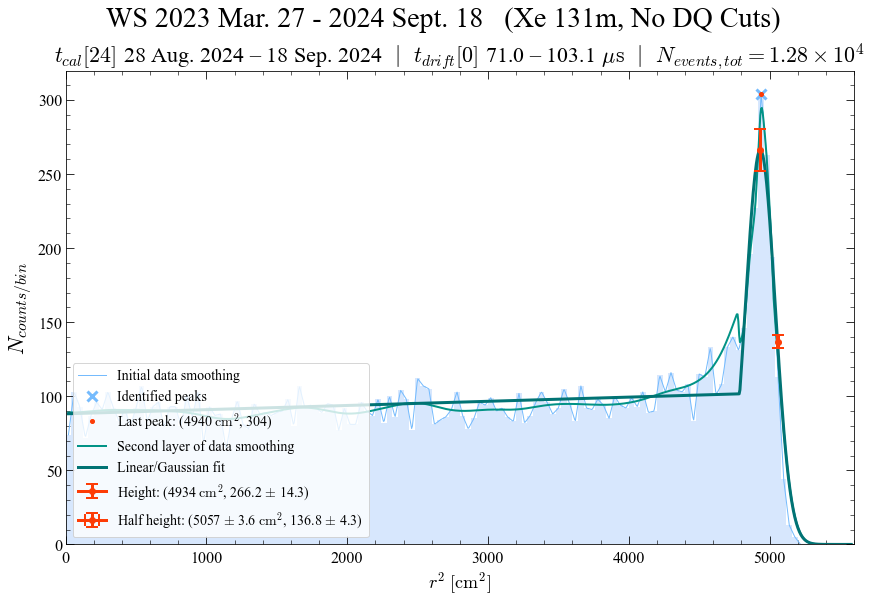

In [55]:
dT_test   = 0

plotting_dict_test = \
find_wall_position(rqs_dict_allcalTdT, 
                   calT_index=calT_test, dT_index=dT_test, 
                   calT_int_dict=calT_int_dict, dT_slice_dict=dT_slice_dict,
                   bin_multiplier_arr=bin_multiplier_arr, 
                   N_too_low=400, hist_range=[0,5.6e3],
                   plot_xrange=[0e3,5.6e3], plot_yrange=None,
                   create_plotting_dict=True, show_plot=True, 
                   flag=False, check_lin_guess=False, param_flag=False, 
                   detailed_param_flag=False, func_prop_flag=False, 
                   use_fixed_b=True, check_hist_props=True)


In [64]:
def checking_something(rqs_dict_allcalTdT, 
                       calT_index, dT_index, 
                       calT_int_dict, dT_slice_dict, 
                       bin_multiplier_arr, 
                       N_too_low=400, 
                       hist_range=[0,5.6e3], 
                       plot_xrange=None, plot_yrange=None, 
                       create_plotting_dict=False, show_plot=False, 
                       flag=False, check_lin_guess=False, 
                       param_flag=False, detailed_param_flag=False, 
                       func_prop_flag=False, use_fixed_b=True, check_hist_props=False):
    
    # select individual slice dictionary
    rqs_dict_1calTdT = rqs_dict_allcalTdT[calT_index][dT_index]
    
    # get necessary values out of dict
    ell_mask   = rqs_dict_1calTdT['ell_mask']
    r2_no_sel  = rqs_dict_1calTdT['r2_cm2']
    r2         = r2_no_sel[ell_mask]
    
    # create mask of values in hist range
    hist_range_mask = (r2 >= hist_range[0]) & (r2 <= hist_range[1])
    
    # get r2 values in hist range
    r2 = r2[hist_range_mask]
    
    # get the number of total events
    num_events_sel_overall = rqs_dict_1calTdT['num_events_sel']
    num_events             = len(r2)
    
    # create an empty plotting dictionary for later
    if create_plotting_dict == True:
        plotting_dict = {}
    
    # do not proceed with calculation if slice is empty
    if num_events < N_too_low:
        
        # set values to 0
        num_events = 0
        num_bins   = 0
    
    # proceed with finding the wall position
    else:
        
        # set the number of histogram bins
        bin_multiplier = bin_multiplier_arr[calT_index][dT_index]
        num_bins       = int(bin_multiplier * np.sqrt(num_events))

    return num_events, num_bins

In [71]:
calT_test_arr     = np.arange(0, 25, dtype=int)
num_events_r2_dT0 = []
num_bins_r2_dT0   = []

for i in range(len(calT_test_arr)):
    
    num_events_r2_calT_dT0, num_bins_r2_calT_dT0 = \
    checking_something(rqs_dict_allcalTdT, 
                       calT_index=calT_test_arr[i], dT_index=dT_test, 
                       calT_int_dict=calT_int_dict, dT_slice_dict=dT_slice_dict,
                       bin_multiplier_arr=bin_multiplier_arr, 
                       N_too_low=400, hist_range=[0,5.6e3])

    if num_bins_r2_calT_dT0 == 0:
        print(f"calT[{i}] is empty")
        print()
    else:
        num_events_r2_dT0.append(num_events_r2_calT_dT0)
        num_bins_r2_dT0.append(num_bins_r2_calT_dT0)

print(f"num_events_r2_dT0 = {num_events_r2_dT0}")
print()
print(f"num_bins_r2_dT0   = {num_bins_r2_dT0}")

calT[2] is empty

num_events_r2_dT0 = [10747, 8387, 16653, 42063, 40411, 44336, 67855, 34119, 6602, 21533, 25201, 13745, 5225, 3405, 15803, 66502, 20431, 16265, 10822, 4110, 62055, 28066, 57574, 12764]

num_bins_r2_dT0   = [131, 118, 153, 193, 191, 194, 200, 186, 107, 166, 174, 143, 96, 79, 151, 199, 164, 152, 131, 86, 199, 178, 198, 140]


slightly_peaked_cond

mu0    = 4698.662873399715
sig0   = 98.51114272166917
split0 = 4698.662873399715
m0     = 0.011653823963527748
b0     = 193.7048936746722

p_scale = [1000, 100, 1000, 0.01, 100.0]

mu     = 4688.813414621415    +- 7.9083695551619035
sig    = 118.21337126151474   +- 3.3327141430101954
split  = 4698.662874551331 +- 40.39021333246104
m      = 0.01684223681384544     +- 0.00020298592813800968
b      = 193.7048936746722     +- 0.0

hh_r2 = 4826.913229018492
hh_n  = 138.37744150956203
hh_dn = 5.448239991650697


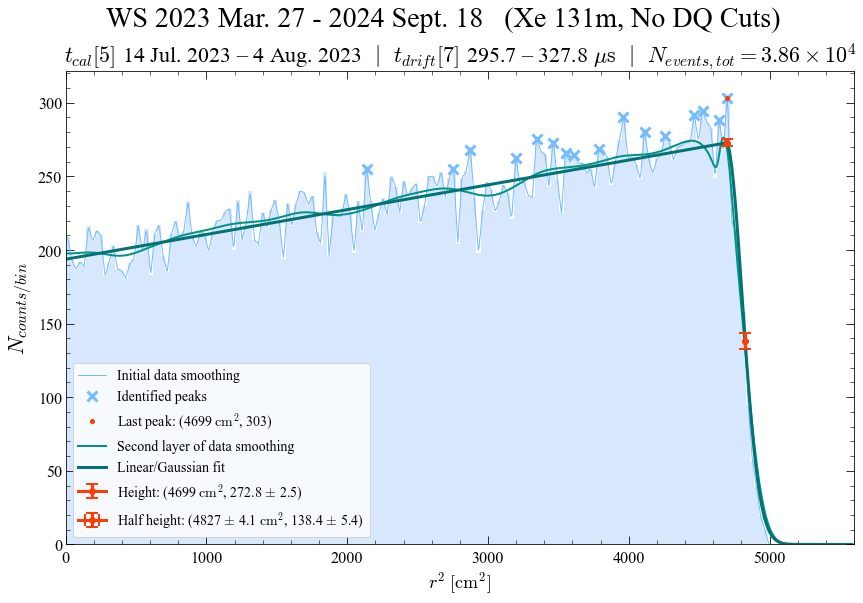

In [1015]:
dT_test   = 7

plotting_dict_test = \
find_wall_position(rqs_dict_allcalTdT, 
                   calT_index=calT_test, dT_index=dT_test, 
                   calT_int_dict=calT_int_dict, dT_slice_dict=dT_slice_dict,
                   bin_multiplier_arr=bin_multiplier_arr, 
                   N_too_low=400, hist_range=[0,5.6e3],
                   plot_xrange=[0e3,5.6e3], plot_yrange=None,
                   create_plotting_dict=True, show_plot=True, 
                   param_flag=True, detailed_param_flag=False, flag=True, 
                   use_fixed_b=True)

else

mu0    = 4631.323631323631
sig0   = 122.64572264572264
split0 = 4631.323631323631
m0     = 0.02536411612741663
b0     = 115.36688995185685

p_scale = [1000, 100, 1000, 0.01, 100.0]

Initial parameter 0 (value: 4631.323631323631) has bounds [4570.00077000077, 4692.646492646492]

Initial parameter 1 (value: 122.64572264572264) has bounds [61.32286132286132, 147.17486717486716]

Initial parameter 2 (value: 4631.323631323631) has bounds [4631.323631323631, 4692.646492646492]

Initial parameter 3 (value: 0.02536411612741663) has bounds [1e-08, 0.05036411612741663]

Initial parameter 4 (value: 115.36688995185685) has bounds [95.36688995185685, 135.36688995185685]

mu     = 4573.507278688692    +- 12.484185994324132
sig    = 147.17479709319272   +- 4.413312465398728
split  = 4631.323631323632 +- 9.689923339993038
m      = 0.034753992776537145     +- 0.00019855697707574647
b      = 115.36688995185685     +- 0.0

hh_r2 = 4753.969353969354
hh_n  = 140.74969647347513
hh_dn = 7.9634554169787

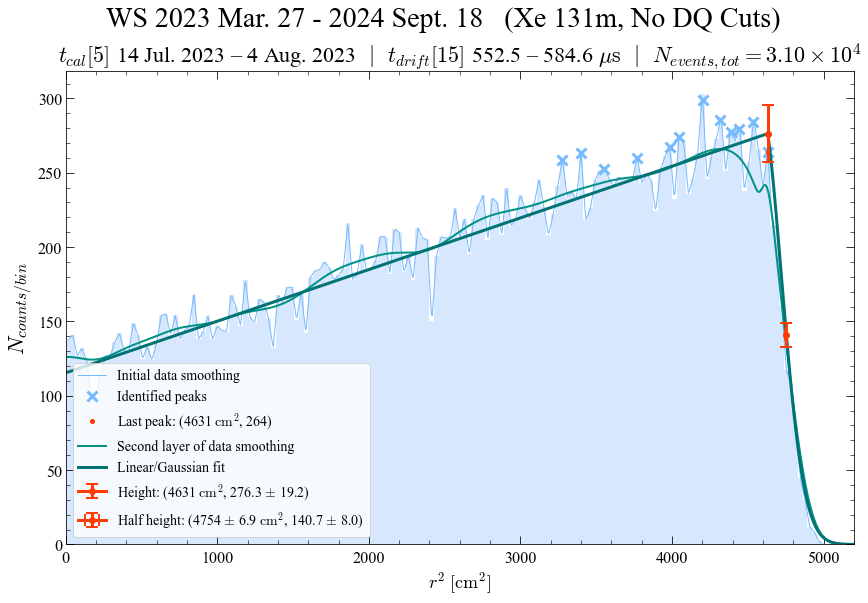

In [1016]:
dT_test   = 15

plotting_dict_test = \
find_wall_position(rqs_dict_allcalTdT, 
                   calT_index=calT_test, dT_index=dT_test, 
                   calT_int_dict=calT_int_dict, dT_slice_dict=dT_slice_dict,
                   bin_multiplier_arr=bin_multiplier_arr, 
                   N_too_low=400, hist_range=[0,5.6e3],
                   plot_xrange=[0e3,5.2e3], plot_yrange=None,
                   create_plotting_dict=True, show_plot=True, 
                   flag=True, param_flag=True, detailed_param_flag=True, 
                   check_lin_guess=False, 
                   use_fixed_b=True)

rather_peaked_cond

mu0    = 4700.839300839301
sig0   = 119.89767545323109
split0 = 4592.931392931393
m0     = 0.002388212195860026
b0     = 40.323407069846624

p_scale = [1000, 100, 1000, 0.001, 10.0]

Initial parameter 0 (value: 4700.839300839301) has bounds [4580.94162538607, 4784.767673656563]

Initial parameter 1 (value: 119.89767545323109) has bounds [59.948837726615544, 155.86697808920042]

Initial parameter 2 (value: 4592.931392931393) has bounds [4532.982555204778, 4676.859765748654]

Initial parameter 3 (value: 0.002388212195860026) has bounds [1e-08, 0.027388212195860028]

Initial parameter 4 (value: 40.323407069846624) has bounds [20.323407069846624, 60.323407069846624]

mu     = 4692.923785889597    +- 3.7652260451734683
sig    = 122.40509236960516   +- 2.388990019597671
split  = 4575.198575750394 +- 5.850539911437095
m      = 0.00278422217094373     +- 9.431290932782619e-05
b      = 40.323407069846624     +- 0.0

hh_r2 = 4839.1827725161065
hh_n  = 41.26456101913828
hh_dn 

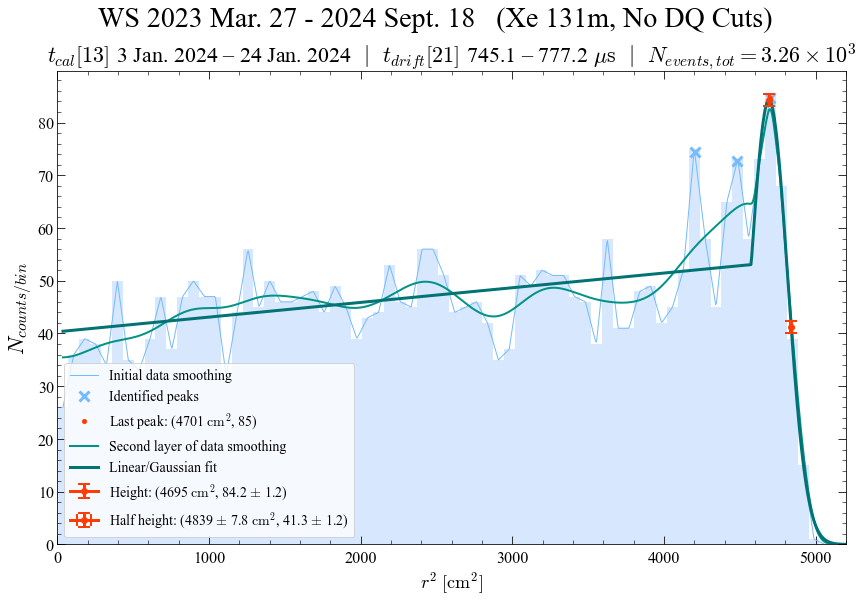

In [985]:
dT_test   = 21

plotting_dict_test = \
find_wall_position(rqs_dict_allcalTdT, 
                   calT_index=calT_test, dT_index=dT_test, 
                   calT_int_dict=calT_int_dict, dT_slice_dict=dT_slice_dict,
                   bin_multiplier_arr=bin_multiplier_arr, 
                   N_too_low=400, hist_range=[0,5.6e3],
                   plot_xrange=[0e3,5.2e3], plot_yrange=None,
                   create_plotting_dict=True, show_plot=True, 
                   param_flag=True, detailed_param_flag=True, flag=True, 
                   use_fixed_b=True)

very_peaked_cond

mu0    = 4419.88494518615
sig0   = 179.06420476701592
split0 = 4061.7565356521177
m0     = 0.002322712180864935
b0     = 40.105095917754326

p_scale = [1000, 100, 1000, 0.001, 10.0]

mu     = 4422.127119917249    +- 2.8074834271634788
sig    = 191.02737363442307   +- 1.7541591979168265
split  = 4168.314231950794 +- 4.533567031384051
m      = 0.0033877635261101956     +- 0.00010988177435414496
b      = 40.105095917754326     +- 0.0

hh_r2 = 4646.945740921645
hh_n  = 65.56989011257541
hh_dn = 1.2605079177664118
{'dr2_dmu': 2.12880543632521, 'dr2_dsig': 0.3227521450448203, 'dr2_ds': 0.5542636212203493, 'dr2_dm': 12475.174774686691, 'dr2_db': 2.9928585227722238, 'dr2_dN': 2.475096723952825}


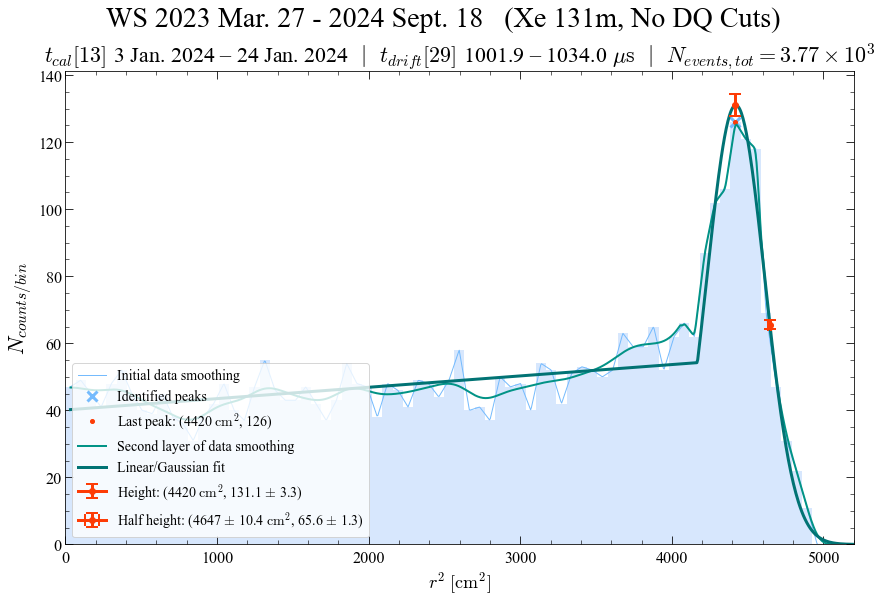

In [986]:
dT_test   = 29

plotting_dict_test = \
find_wall_position(rqs_dict_allcalTdT, 
                   calT_index=calT_test, dT_index=dT_test, 
                   calT_int_dict=calT_int_dict, dT_slice_dict=dT_slice_dict,
                   bin_multiplier_arr=bin_multiplier_arr, 
                   N_too_low=400, hist_range=[0,5.6e3],
                   plot_xrange=[0e3,5.2e3], plot_yrange=None,
                   create_plotting_dict=True, show_plot=True, 
                   flag=True, param_flag=True, 
                   detailed_param_flag=False, check_lin_guess=False, 
                   use_fixed_b=True)

## create plots - one $t_{drift}$ all $t_{cal}$

### function

In [1086]:
def plot_wall_position_1dT_all_calT(rqs_dict_allcalTdT, 
                                    calT_int_dict, dT_slice_dict, 
                                    bin_multiplier_arr, dT_index, 
                                    plot_xrange, plot_yrange,
                                    plots_per_row = 5):
    
    # get number of calT slices
    num_slices = len(calT_int_dict)
    
    # Calculate the number of full rows and the number of plots in the last row
    full_rows = num_slices // plots_per_row
    remainder = num_slices % plots_per_row

    # Create the list for the number of plots per row
    ppr = [plots_per_row] * full_rows
    if remainder != 0:
        ppr.append(remainder)

    # make sure there are only the number of plots in each row necessary 
    ppr[-1] = num_slices - sum(ppr[:-1]) 
    num_rows = len(ppr)
    
    # Set up the figure and subplots
    fig, axs = plt.subplots(num_rows, np.max(ppr), figsize=(60, num_rows * 10))

    # Flatten the axs array for easier indexing
    axs = axs.flatten()
    
    # loop through calendar time intervals 
    for i in range(num_slices):
        
        print(f"calT[{i}]")
        
        # get plotting dict of individual calT dT slices
        plotting_dict = \
        find_wall_position(rqs_dict_allcalTdT=rqs_dict_allcalTdT, 
                           calT_index=i, 
                           dT_index=dT_index, 
                           calT_int_dict=calT_int_dict, 
                           dT_slice_dict=dT_slice_dict, 
                           bin_multiplier_arr=bin_multiplier_arr, 
                           plot_xrange=plot_xrange, plot_yrange=plot_yrange,
                           create_plotting_dict=True, show_plot=False)
        
        # get values out of plotting dict
        if len(plotting_dict) == 0:
            
            # leave axis blank
            axs[i].axis("off")
            
        else: 
            # set up current subplot
            ax = axs[i]
            
            # limit plot range, if desired
            if plot_xrange is not None:
                ax.set_xlim(plot_xrange)
            if plot_yrange is not None:
                ax.set_ylim(plot_yrange)
            
            # get global labeling variables
            global data_str, data_plot_str, source_str, source_plot_str, veto_str, veto_plot_str
            
            # get axis labels and title
            xlabel           = plotting_dict['xlabel']
            ylabel           = plotting_dict['ylabel']
            dT_label         = plotting_dict['dT_label']
            calT_label       = plotting_dict['calT_label']
            num_events_label = plotting_dict['num_events_label']
            ylabel           = f"{ylabel}$~~|~~N_{{tot}}={num_events_label}$"
            main_title       = f"{data_plot_str}   ({source_plot_str}, {veto_plot_str})   $t_{{drift}}$[{dT_index}] {dT_label}"
            subtitle         = f"$t_{{cal}}$[{i}] {calT_label}"
            
            # set axis labels and title
            ax.set_xlabel(xlabel,     fontsize=40)
            ax.set_ylabel(ylabel,     fontsize=40)
            ax.set_title (subtitle,   fontsize=48, y=1.05)
            fig.suptitle (main_title, fontsize=72, y=1.02)
            
            # get histogram values 
            hist_vals_r2    = plotting_dict['hist_vals_r2']
            hist_bin_widths = plotting_dict['hist_bin_widths']
            hist_vals_n     = plotting_dict['hist_vals_n']
            
            # plot histogram
            ax.bar(hist_vals_r2, hist_vals_n, width=hist_bin_widths,
                   color='xkcd:powder blue', alpha=0.5)
            
            # get smoothed values
            smooth_r2 = plotting_dict['smooth_r2']
            smooth_n  = plotting_dict['smooth_n']
            
            # plot smoothed values
            ax.plot(smooth_r2, smooth_n, 
                    ls='-', lw=1, 
                    color='xkcd:sky blue')#, label='Initial data smoothing')
            
            # get peak values
            peak_r2_vals = plotting_dict['peak_r2_vals']
            peak_n_vals  = plotting_dict['peak_n_vals']
            
            # plot peak values
            ax.plot(peak_r2_vals, peak_n_vals, 
                    ls='', marker='x', ms=10, mew=3, 
                    color='xkcd:sky blue')#, label='Identified peaks')
            
            # get last peak values
            last_peak_r2 = plotting_dict['last_peak_r2']
            last_peak_n  = plotting_dict['last_peak_n']
            
            # plot last peak values
            ax.plot(last_peak_r2, last_peak_n, 
                    ls='', marker='o', ms=4,  
                    color='xkcd:red orange')#, label=f"Last peak: ({int(np.round(last_peak_r2))} $\mathrm{{cm^2}}$, {int(np.round(last_peak_n))})")
            
            # get second layer of smoothing smoothed values
            r2_smooth = plotting_dict['r2_smooth']
            n_smooth  = plotting_dict['n_smooth']
            
            # plot second layer of smoothing smoothed values
            ax.plot(r2_smooth, n_smooth, 
                    ls='-', lw=2, 
                    color='xkcd:teal')#, label='Second layer of data smoothing')
            
            # get linear/gaussian fit values
            r2_lin_gauss_fit = plotting_dict['r2_lin_gauss_fit']
            n_lin_gauss_fit  = plotting_dict['n_lin_gauss_fit']
            
            # plot linear/gaussian fit values
            ax.plot(r2_lin_gauss_fit, n_lin_gauss_fit, 
                    ls='-', lw=3, 
                    color='xkcd:deep turquoise', 
                    label='Linear/Gaussian fit')
            
            # get height point values
            r2_height = plotting_dict['r2_height']
            n_height  = plotting_dict['n_height']
            dn_height = plotting_dict['dn_height']
            
            # plot height point
            ax.errorbar(r2_height, n_height, yerr=dn_height, 
                        marker='o', ms=6, capsize=6, capthick=2, lw=3, zorder=10,
                        color='xkcd:red orange', 
                        label=f"Height: ({int(np.round(r2_height))} $\mathrm{{cm^2}}$, {np.round(n_height,1)} $\pm$ {np.round(dn_height,1)})")
            
            # get the half height point values
            hh_r2  = plotting_dict['hh_r2']
            hh_dr2 = plotting_dict['hh_dr2']
            hh_n   = plotting_dict['hh_n']
            hh_dn  = plotting_dict['hh_dn']
            
            # plot the half height point with error 
            ax.errorbar(hh_r2, hh_n, xerr=hh_dr2, yerr=hh_dn, 
                        marker='o', ms=6, capsize=6, capthick=2, lw=3, zorder=10,
                        color='xkcd:red orange', 
                        label=f"Half height: ({int(np.round(hh_r2))} $\pm$ {np.round(hh_dr2,1)} $\mathrm{{cm^2}}$, {np.round(hh_n,1)} $\pm$ {np.round(hh_dn,1)})")
            
            
            # add legend
            ax.legend(loc='lower left', fontsize=30)
            
            
    fig.tight_layout(pad=2.0)
    for j in range(num_slices, len(axs)): 
        fig.delaxes(axs[j]) 

        

### plots

calT[0]
calT[1]
calT[2]
calT[3]
calT[4]
calT[5]
calT[6]
calT[7]
calT[8]
calT[9]
calT[10]
calT[11]
calT[12]
calT[13]
calT[14]
calT[15]
calT[16]
calT[17]
calT[18]
calT[19]
calT[20]
calT[21]
calT[22]
calT[23]
calT[24]


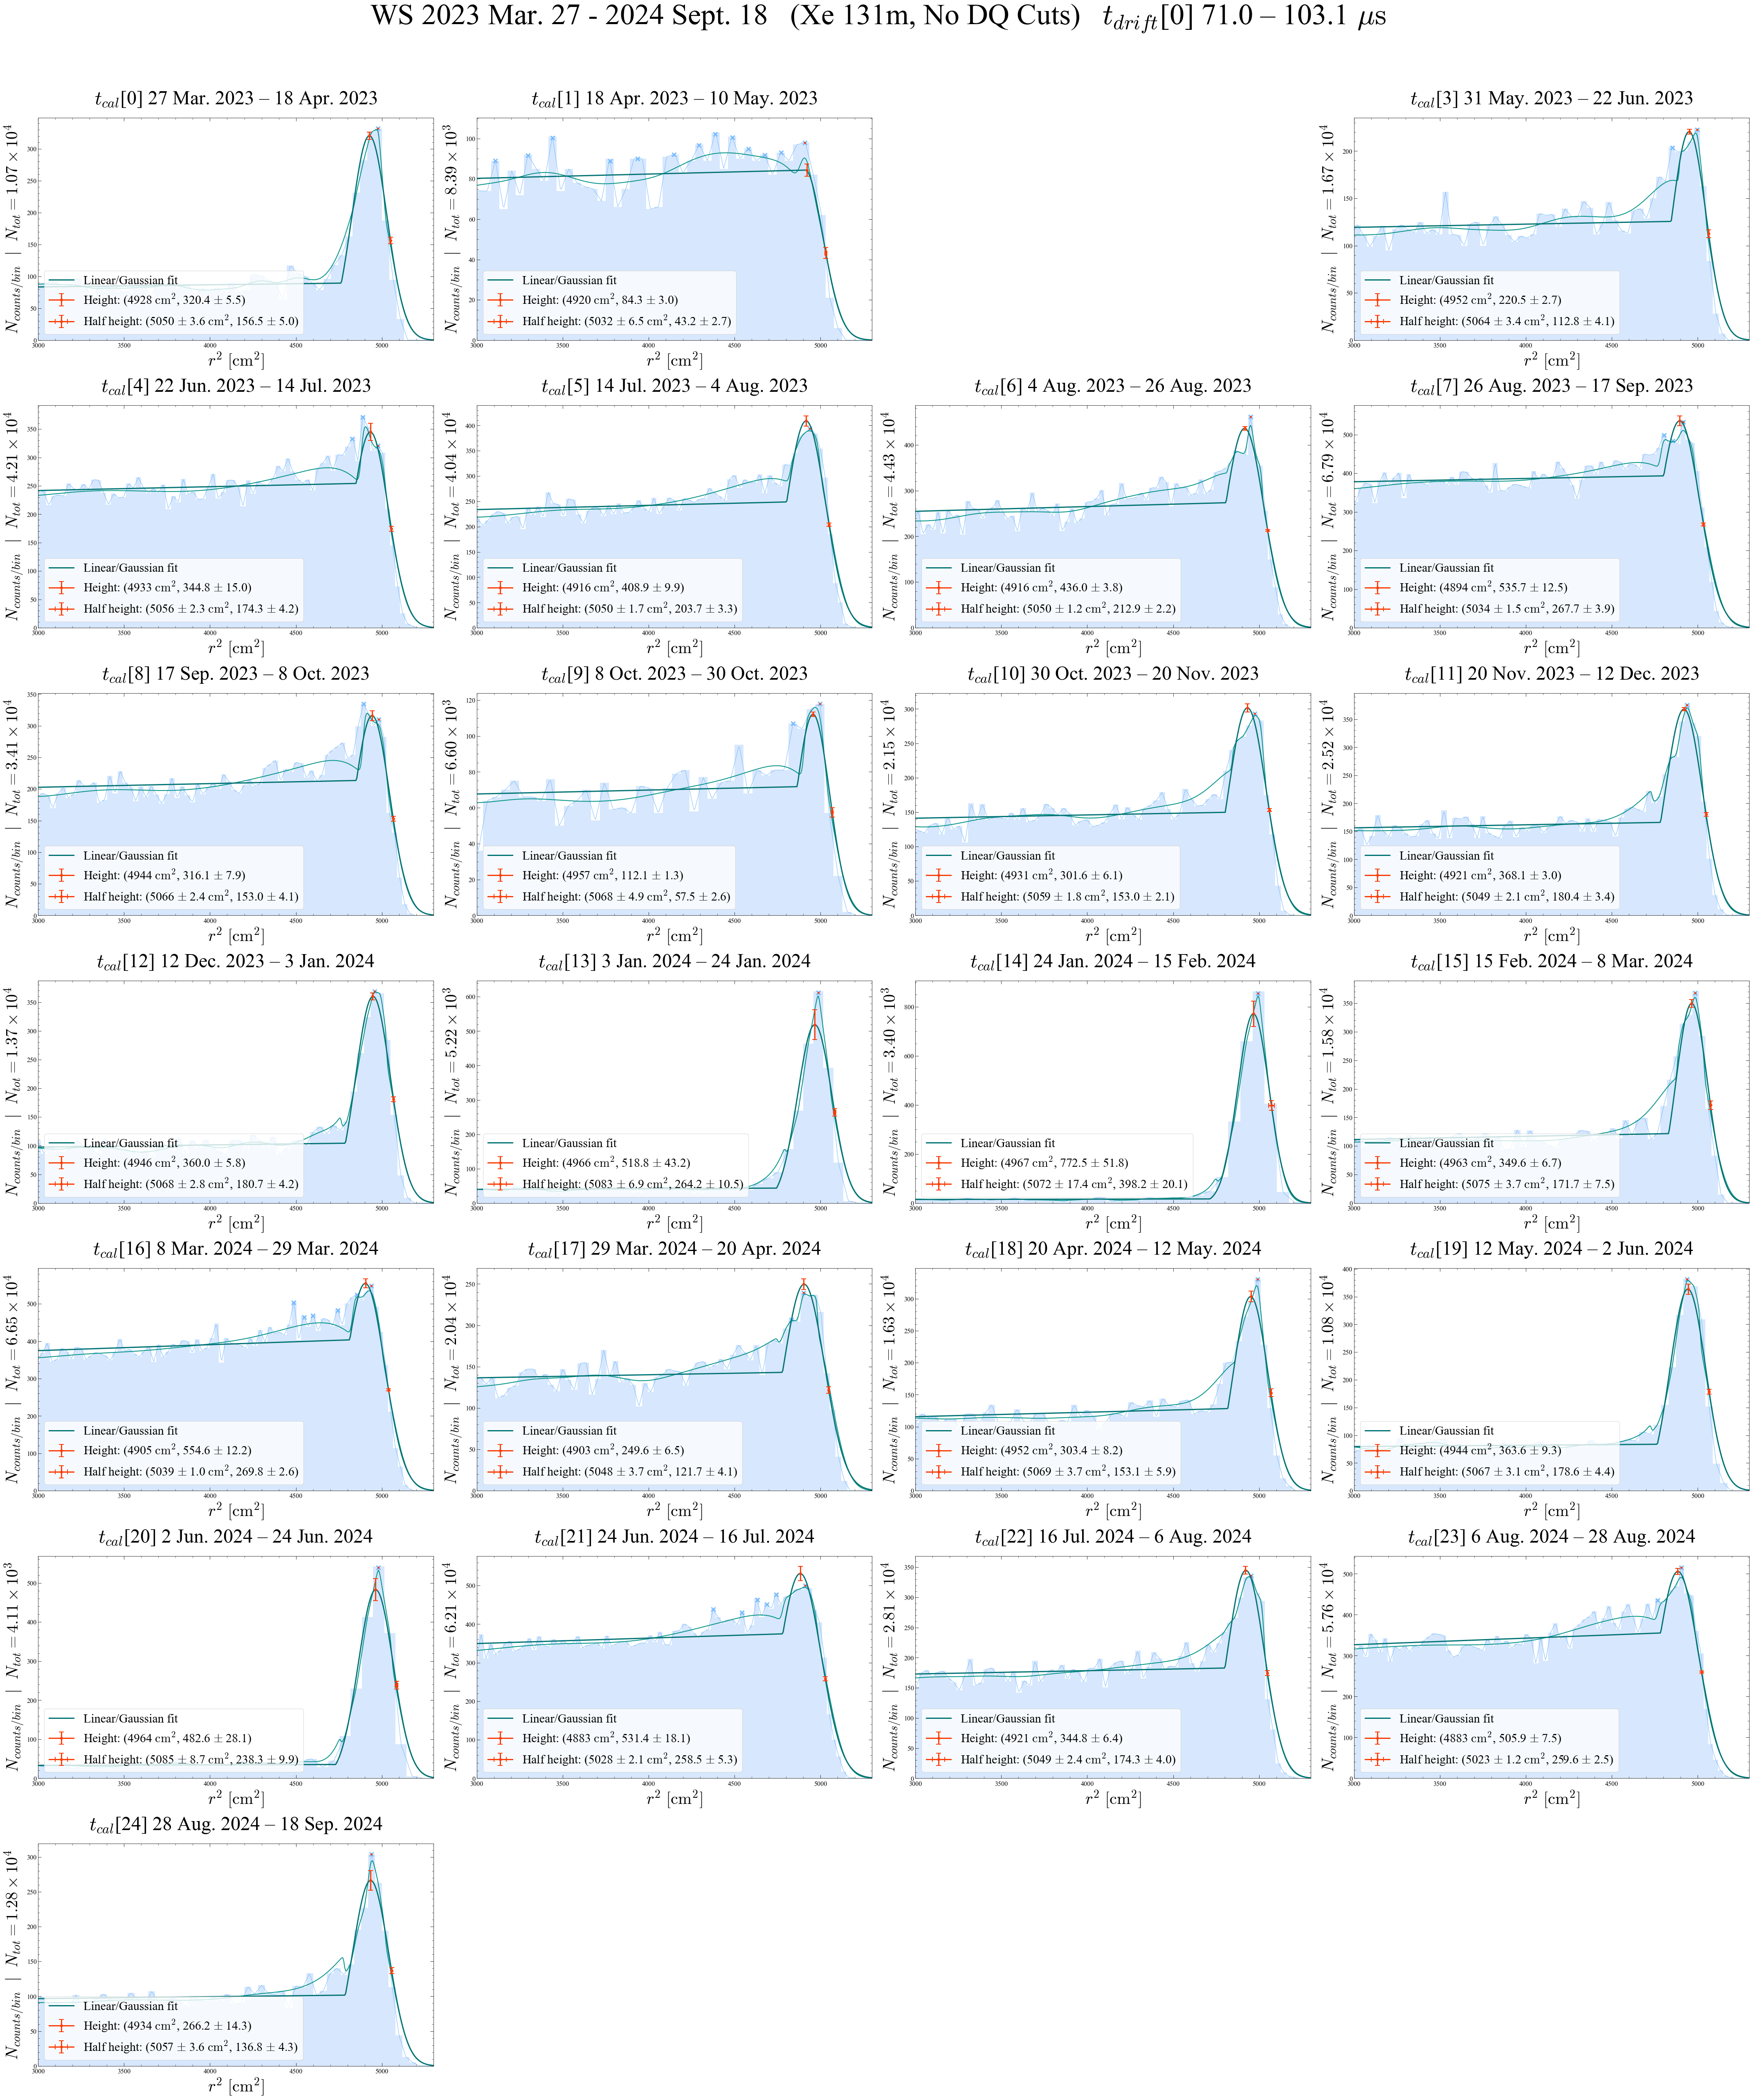

In [1087]:
plot_wall_position_1dT_all_calT(rqs_dict_allcalTdT, 
                                calT_int_dict, dT_slice_dict, 
                                bin_multiplier_arr, dT_index=0, 
                                plot_xrange=[3e3,5.3e3], 
                                plot_yrange=None, 
                                plots_per_row = 4)
